# Import of packages

The analysis pipeline uses 'autoprot' developed in our lab (https://doi.org/10.1101/2024.01.18.571429)

Autoprot is implemented in Python ≥ 3.9 and can be downloaded from https://github.com/ag-warscheid/autoprot. Online documentation is available at https://ag-warscheid.github.io/autoprot/.

In [1]:
import os
import urllib
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pylab as plt
import numpy as np
import itertools

import plotly.graph_objects as go
import plotly.express as px

import missingno as msn
import logomaker

from autoprot_dev import preprocessing as pp
from autoprot_dev import analysis as ana
from autoprot_dev import visualization as vis

from subprocess import run, PIPE

import warnings
warnings.filterwarnings('ignore')

cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)

%matplotlib inline

import datetime

date = datetime.date.today().strftime('%Y%m%d')
dirname = os.getcwd()[:-8]
rootdir = dirname

#important that font get exportet properly
# plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['pdf.fonttype'] = 42



COLORS = [ "cyan", "#dede00", "#377eb8", "#ffff00", "#e68a00", "#99ccff", 
          "#00ffcc", "#ff99ff", "#00b386","pink", "magenta"]


HUE_ORDER = ['Mitochondria','Acidocalcisome','ER', 'Cytoplasm','Nucleus','Nuclear Pore',
             'Cytoskeleton','Plasma membrane','Golgi', 'Glycosomal matrix', 'Glycosomal membrane']

Checking R installation...
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)
Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocManager
Bioconductor version '3.16' is out-of-date; the current release version '3.19'
is available with R version '4.4'; see https://bioconductor.org/install
Loading required package: devtools
Loading required package: usethis
Attaching package: ‘devtools’
The 

# Data Import

In [2]:
df = pd.read_csv("txt/proteinGroups.txt", sep='\t')
df.sample(1)

Protein IDs  Majority protein IDs Peptide counts (all)  \
727  Tb427_030045600.1-p1  Tb427_030045600.1-p1                    4   

    Peptide counts (razor+unique) Peptide counts (unique)  \
727                             4                       4   

                        Fasta headers  Number of proteins  Peptides  \
727  hypothetical protein, conserved                    1         4   

     Razor + unique peptides  Unique peptides  ...   id  \
727                        4                4  ...  727   

                 Peptide IDs     Peptide is razor  \
727  26751;27971;43140;45154  True;True;True;True   

                  Mod. peptide IDs  \
727  29795;31445;31446;48649;50913   

                                          Evidence IDs  \
727  245848;245849;245850;245851;258320;258321;2583...   

                                             MS/MS IDs  \
727  223493;223494;223495;234462;234463;234464;2344...   

                      Best MS/MS  Oxidation (M) site IDs  \
727  223495;234465;366304;382216                     849   

     Oxidation (M) site positions  Taxonomy IDs  
727                             1            -1  

[1 rows x 297 columns]

In [3]:
df = pp.cleaning(df)

4582 rows before filter operation.
4317 rows after filter operation.


Removing the text string '.1-p1' present in the identifiers of the fasta file used for MQ search

In [4]:
df['Majority protein IDs'] = df['Majority protein IDs'].str.replace('.1-p1','')
df['Protein IDs'] = df['Protein IDs'].str.replace('.1-p1','')

In [5]:
df.filter(regex="Intensity ").columns

Index(['Intensity Rep1_Density_F11', 'Intensity Rep1_Density_F12',
       'Intensity Rep1_Density_F13', 'Intensity Rep1_Density_F14',
       'Intensity Rep1_Density_F15', 'Intensity Rep1_Density_F16',
       'Intensity Rep1_Density_F17', 'Intensity Rep1_Density_F18',
       'Intensity Rep1_Density_F19', 'Intensity Rep1_Density_F20',
       'Intensity Rep1_Density_F21', 'Intensity Rep1_Density_F22',
       'Intensity Rep1_NP', 'Intensity Rep1_SN0', 'Intensity Rep1_SN1',
       'Intensity Rep1_SN2', 'Intensity Rep1_Total_Glycosome',
       'Intensity Rep2_NP', 'Intensity Rep2_OP', 'Intensity Rep2_SN0',
       'Intensity Rep2_SN1', 'Intensity Rep2_SN2',
       'Intensity Rep2_Total_Glycosome', 'Intensity Rep3_NP',
       'Intensity Rep3_OP', 'Intensity Rep3_SN0', 'Intensity Rep3_SN1',
       'Intensity Rep3_SN2', 'Intensity Rep3_Total_Glycosome'],
      dtype='object')

In [6]:
df.filter(regex="_NP").columns

Index(['Peptides Rep1_NP', 'Peptides Rep2_NP', 'Peptides Rep3_NP',
       'Razor + unique peptides Rep1_NP', 'Razor + unique peptides Rep2_NP',
       'Razor + unique peptides Rep3_NP', 'Unique peptides Rep1_NP',
       'Unique peptides Rep2_NP', 'Unique peptides Rep3_NP',
       'Identification type Rep1_NP', 'Identification type Rep2_NP',
       'Identification type Rep3_NP', 'Sequence coverage Rep1_NP [%]',
       'Sequence coverage Rep2_NP [%]', 'Sequence coverage Rep3_NP [%]',
       'Intensity Rep1_NP', 'Intensity Rep2_NP', 'Intensity Rep3_NP',
       'iBAQ Rep1_NP', 'iBAQ Rep2_NP', 'iBAQ Rep3_NP', 'LFQ intensity Rep1_NP',
       'LFQ intensity Rep2_NP', 'LFQ intensity Rep3_NP', 'MS/MS count Rep1_NP',
       'MS/MS count Rep2_NP', 'MS/MS count Rep3_NP'],
      dtype='object')

In [7]:
np_columns = df.filter(regex="_NP").columns

rename_dict = {col: col.replace('_NP', '_MP') for col in np_columns}

df = df.rename(columns=rename_dict)

In [8]:
df.filter(regex="_MP").columns

Index(['Peptides Rep1_MP', 'Peptides Rep2_MP', 'Peptides Rep3_MP',
       'Razor + unique peptides Rep1_MP', 'Razor + unique peptides Rep2_MP',
       'Razor + unique peptides Rep3_MP', 'Unique peptides Rep1_MP',
       'Unique peptides Rep2_MP', 'Unique peptides Rep3_MP',
       'Identification type Rep1_MP', 'Identification type Rep2_MP',
       'Identification type Rep3_MP', 'Sequence coverage Rep1_MP [%]',
       'Sequence coverage Rep2_MP [%]', 'Sequence coverage Rep3_MP [%]',
       'Intensity Rep1_MP', 'Intensity Rep2_MP', 'Intensity Rep3_MP',
       'iBAQ Rep1_MP', 'iBAQ Rep2_MP', 'iBAQ Rep3_MP', 'LFQ intensity Rep1_MP',
       'LFQ intensity Rep2_MP', 'LFQ intensity Rep3_MP', 'MS/MS count Rep1_MP',
       'MS/MS count Rep2_MP', 'MS/MS count Rep3_MP'],
      dtype='object')

In [9]:
df.columns = df.columns.str.replace(r"Rep3_MP", "ABCD")
df.columns = df.columns.str.replace(r"Rep3_Total_Glycosome", "XYZ")

df.columns = df.columns.str.replace(r"XYZ", "Rep3_MP")
df.columns = df.columns.str.replace(r"ABCD", "Rep3_Total_Glycosome")

In [10]:
df.columns = df.columns.str.replace(r"Rep3_SN0", "ABCD")
df.columns = df.columns.str.replace(r"Rep3_SN1", "XYZ")

df.columns = df.columns.str.replace(r"XYZ", "Rep3_SN0")
df.columns = df.columns.str.replace(r"ABCD", "Rep3_SN1")

# Marker annotation

In [11]:
marker = pp.read_csv("marker_list/Tb Markers CKK V04.txt")

In [12]:
marker.columns

Index(['Description', 'ProteinID_927', 'ProteinID_427', 'marker',
       'Trace_validated', 'Comments'],
      dtype='object')

In [13]:
df["UID"] = range(1, df.shape[0]+1)
df_copy = df.copy()
df_copy['Majority protein IDs'] = df_copy['Majority protein IDs'].str.split(';')
df_copy = df_copy.explode('Majority protein IDs')

In [14]:
merged_df = df_copy.merge(marker, left_on='Majority protein IDs', right_on='ProteinID_427', how='right')
merged_df = merged_df.groupby('UID').agg("max")
df2 = df.merge(merged_df, on='UID', how='left', suffixes=('', '_y'))
df2.drop(df2.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [15]:
df_marker = df2.copy(deep=True)

Visualizing first few and last few rows to identify correct merge:

In [16]:
df2[df2['marker']=='Glycosomal membrane'].iloc[:, :2].join(df2[df2['marker']=='Glycosomal membrane'].iloc[:, -6:])

Protein IDs Majority protein IDs Description   ProteinID_927  \
403   Tb427_030023100      Tb427_030023100        PEX2    Tb927.3.2340   
407   Tb427_030023800      Tb427_030023800       PEX10    Tb927.3.2410   
769   Tb427_040043200      Tb427_040043200        GAT1    Tb927.4.4050   
2273  Tb427_090036100      Tb427_090036100       PEX16    Tb927.9.6450   
2358  Tb427_090053600      Tb427_090053600     PEX13.2    Tb927.9.9430   
2435  Tb427_090066100      Tb427_090066100       GIM5A   Tb927.9.11580   
2436  Tb427_090066200      Tb427_090066200       GIM5B   Tb927.9.11600   
3330  Tb427_100155500      Tb427_100155500    PEX13.1   Tb927.10.14720   
3389  Tb427_100168100      Tb427_100168100       PEX12  Tb927.10.15850   
3570  Tb427_110036300      Tb427_110036300        GAT2   Tb927.11.3130   
3961  Tb427_110111200      Tb427_110111200        PEX3  Tb927.11.10260   
4040  Tb427_110131800      Tb427_110131800       PEX11  Tb927.11.11520   

        ProteinID_427               marker Trace_validated Comments  
403   Tb427_030023100  Glycosomal membrane             yes      NaN  
407   Tb427_030023800  Glycosomal membrane             yes      NaN  
769   Tb427_040043200  Glycosomal membrane             yes      NaN  
2273  Tb427_090036100  Glycosomal membrane             yes      NaN  
2358  Tb427_090053600  Glycosomal membrane             yes      NaN  
2435  Tb427_090066100  Glycosomal membrane             yes      NaN  
2436  Tb427_090066200  Glycosomal membrane             yes      NaN  
3330  Tb427_100155500  Glycosomal membrane             yes      NaN  
3389  Tb427_100168100  Glycosomal membrane             yes      NaN  
3570  Tb427_110036300  Glycosomal membrane             yes      NaN  
3961  Tb427_110111200  Glycosomal membrane             yes      NaN  
4040  Tb427_110131800  Glycosomal membrane             yes      NaN

In [17]:
marker['marker'].value_counts()

marker
Glycosomal matrix      19
Nucleus                16
ER                     14
Glycosomal membrane    12
Golgi                  11
Cytoskeleton           11
Nuclear Pore           11
Plasma membrane        10
Acidocalcisome         10
Cytoplasm               8
Mitochondria            7
Glyco_mito              2
Glyco_Cyto              1
Name: count, dtype: int64

In [18]:
df2['marker'].value_counts()

marker
Glycosomal matrix      18
ER                     14
Glycosomal membrane    12
Cytoskeleton           11
Golgi                  10
Acidocalcisome          9
Cytoplasm               8
Nucleus                 8
Nuclear Pore            7
Mitochondria            6
Plasma membrane         6
Glyco_mito              2
Glyco_Cyto              1
Name: count, dtype: int64

In [19]:
df_main = df2.copy(deep=True)

In [20]:
# df2.to_csv("results/proteinGroups_with_markers.csv", index=False)

# Analysis 1: PCP of all conditions-

In [21]:
df_traces = df2.copy(deep=True)

In [22]:
df_traces.filter(regex='^iBAQ Rep').columns

Index(['iBAQ Rep1_Density_F11', 'iBAQ Rep1_Density_F12',
       'iBAQ Rep1_Density_F13', 'iBAQ Rep1_Density_F14',
       'iBAQ Rep1_Density_F15', 'iBAQ Rep1_Density_F16',
       'iBAQ Rep1_Density_F17', 'iBAQ Rep1_Density_F18',
       'iBAQ Rep1_Density_F19', 'iBAQ Rep1_Density_F20',
       'iBAQ Rep1_Density_F21', 'iBAQ Rep1_Density_F22', 'iBAQ Rep1_MP',
       'iBAQ Rep1_SN0', 'iBAQ Rep1_SN1', 'iBAQ Rep1_SN2',
       'iBAQ Rep1_Total_Glycosome', 'iBAQ Rep2_MP', 'iBAQ Rep2_OP',
       'iBAQ Rep2_SN0', 'iBAQ Rep2_SN1', 'iBAQ Rep2_SN2',
       'iBAQ Rep2_Total_Glycosome', 'iBAQ Rep3_Total_Glycosome',
       'iBAQ Rep3_OP', 'iBAQ Rep3_SN1', 'iBAQ Rep3_SN0', 'iBAQ Rep3_SN2',
       'iBAQ Rep3_MP'],
      dtype='object')

## Selecting iBAQ intensity columns for further analysis:

In [23]:
ointCol1 = ['iBAQ Rep1_Total_Glycosome', 'iBAQ Rep1_SN0', 'iBAQ Rep1_SN1',
       'iBAQ Rep1_SN2', 'iBAQ Rep1_MP']
ointCol2 = ['iBAQ Rep2_Total_Glycosome', 'iBAQ Rep2_SN0', 'iBAQ Rep2_SN1',
       'iBAQ Rep2_SN2', 'iBAQ Rep2_MP']
ointCol3 = ['iBAQ Rep3_Total_Glycosome', 'iBAQ Rep3_SN0', 'iBAQ Rep3_SN1',
       'iBAQ Rep3_SN2', 'iBAQ Rep3_MP']

ointCols = [ointCol1, ointCol2, ointCol3]

sumCols = ointCol1 + ointCol2 + ointCol3

In [24]:
df_traces = pp.remove_non_quant(df_traces, ointCol1 + ointCol2 + ointCol3)

4317 rows before filter operation.
4317 rows after filter operation.


In [25]:
intCols = []

for ointCol in ointCols:
    df_traces[ointCol] = df_traces[ointCol].replace(0, np.nan)
    df_traces, intCol = pp.log(df_traces, ointCol, base=10, return_cols=True)
    intCols.append(intCol)

In [26]:
# df_traces["UID"] = range(1, df_traces.shape[0]+1)

<Axes: >

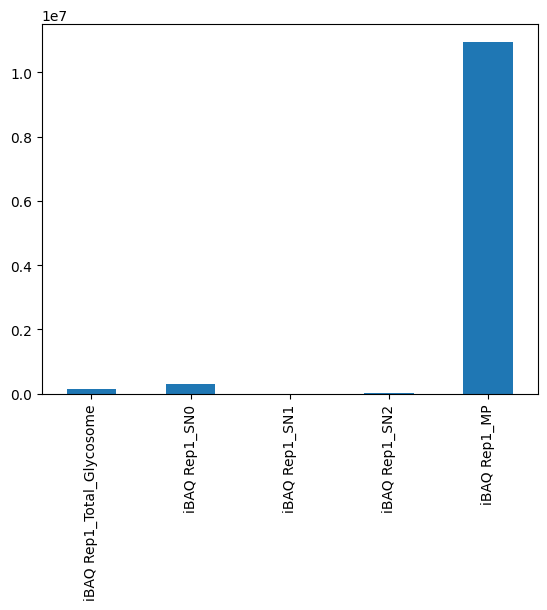

In [27]:
df[df['Majority protein IDs'].str.contains('Tb427_090008200')][ointCol1].mean().plot(kind='bar')

<Axes: >

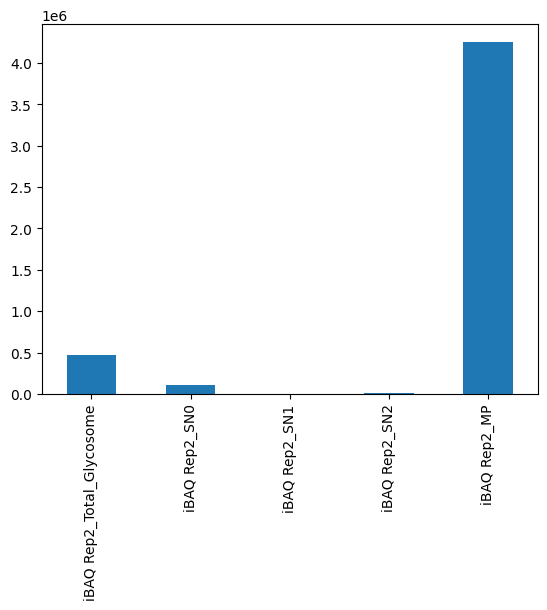

In [28]:
df[df['Majority protein IDs'].str.contains('Tb427_090008200')][ointCol2].mean().plot(kind='bar')

<Axes: >

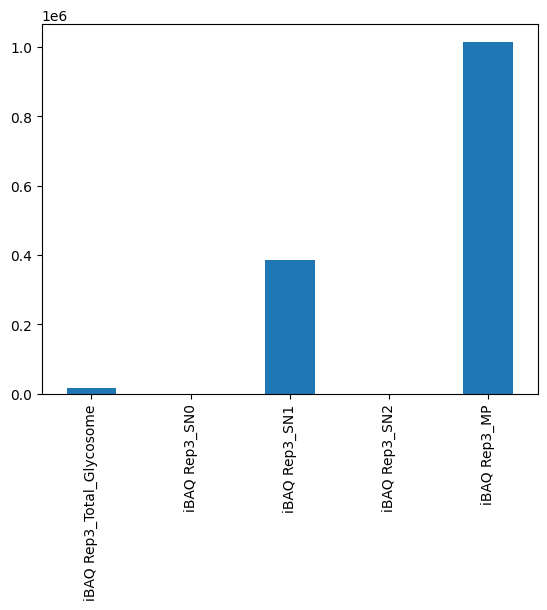

In [29]:
df[df['Majority protein IDs'].str.contains('Tb427_090008200')][ointCol3].mean().plot(kind='bar')

## Visualizing overlap of proteins identified in membrane pellet fraction of rep1, rep2 and rep3:

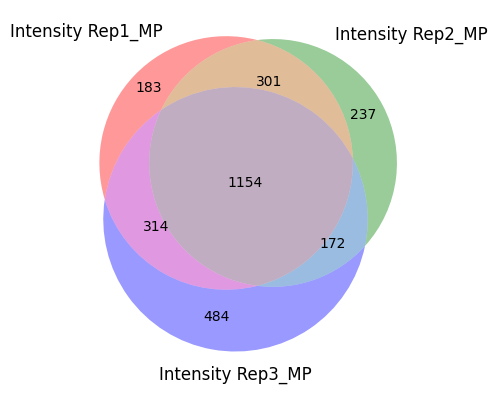

In [30]:
vis.venn_diagram(df_traces[['Intensity Rep1_MP', 'Intensity Rep2_MP', 'Intensity Rep3_MP']].replace(0, np.nan))

## Data preprocessing for all reps:

In [31]:
from sklearn.preprocessing import MinMaxScaler


for rep in range(3):
    intCol= intCols[rep]

    df_filter = df_traces.copy(deep=True)
    df_filter = pp.remove_non_quant(df_filter, intCol)
    ## Filtering dataset by rows which have at least 2 valid values out of 5 columns 'Total', 'SN', 'SN1','SN2', 'MP'
    """
    ## This is based on the assumption that a membrane protein may be enriched only in Total glycosomal and then 
    directly in the membrane pellet with missing values in the washing steps 'SN0', 'SN1' and 'SN2'.
    
    
    """
    df_filter = pp.filter_vv(df_filter, [intCol], n=2, valid_values=True)

    ## Imputing missing values for each row by randomly drawing values from downshifted distribution across rows:
    def impute_per_row(row):
        
        downshift = 1.8
        width = .3
        
        var = np.std(row)
        mean = np.mean(row)

        mean_ = mean - downshift*var
        var_ = var*width

        
        rnd = list(np.random.normal(mean_, var_, size=np.isnan(row).sum()))
        
        idx_noCtrl = row[row.isnull()].index
                
        for i, idx in enumerate(idx_noCtrl):
            row[idx] = rnd[i]
                
        return row
    
    df_filter[intCol] = df_filter[intCol].apply(impute_per_row, axis=1)

    
    df_norm2 = df_filter.copy(deep=True)
    
    ################  MIN-MAX NORMALIZATION ###############################
    df_norm2[intCol] = 10**df_norm2[intCol]

    df_norm2[intCol] = df_norm2[intCol].apply(lambda x: x/max(x), 1)

        
    df_norm2.to_csv("results/dataset1_rep" + str(rep+1) + ".csv", index=False)


4317 rows before filter operation.
2768 rows after filter operation.
2768 rows before filter operation.
1929 rows after filter operation.
4317 rows before filter operation.
2806 rows after filter operation.
2806 rows before filter operation.
1894 rows after filter operation.
4317 rows before filter operation.
3902 rows after filter operation.
3902 rows before filter operation.
2337 rows after filter operation.


## Loading preprocessed dataset from each replicate as a separate dataframe:

As each replicate dataframe is reduced after filtering for valid values and imputing missing values, we load each dataset separately.

In [32]:
rep1 = pp.read_csv("results/dataset1_rep1.csv", sep=',')
rep2 = pp.read_csv("results/dataset1_rep2.csv", sep=',')
rep3 = pp.read_csv("results/dataset1_rep3.csv", sep=',')

## Visualization of traces for QC of marker proteins:

In [33]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def create_custom_legend(moi, COLORS=None, ax=None):
    if COLORS is None:
        # Use the 'qualitative' 'Set1' color palette from matplotlib
        COLORS = plt.cm.Set1.colors[:len(moi)]

    # Create a list of Line2D objects for the legend
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for label, color in zip(moi, COLORS)]

    if ax is None:
        # If no axes object is provided, get the current axes
        ax = plt.gca()

    # Add the custom legend to the specified axes object
    ax.legend(handles=legend_elements, loc='best', fontsize='small', title="Marker/Protein")

    return ax

In [34]:
intCol1 = ['log10_iBAQ Rep1_Total_Glycosome', 'log10_iBAQ Rep1_SN0',
       'log10_iBAQ Rep1_SN1', 'log10_iBAQ Rep1_SN2',
       'log10_iBAQ Rep1_MP']

intCol2 = ['log10_iBAQ Rep2_Total_Glycosome', 'log10_iBAQ Rep2_SN0',
       'log10_iBAQ Rep2_SN1', 'log10_iBAQ Rep2_SN2',
       'log10_iBAQ Rep2_MP']

intCol3 = ['log10_iBAQ Rep3_Total_Glycosome', 'log10_iBAQ Rep3_SN0',
       'log10_iBAQ Rep3_SN1', 'log10_iBAQ Rep3_SN2',
       'log10_iBAQ Rep3_MP']

### Visualizing mean of marker proteins per rep:

In [35]:
moi = ['Mitochondria','Acidocalcisome','ER', 'Cytoplasm','Nucleus','Nuclear Pore',
             'Cytoskeleton','Plasma membrane','Golgi', 'Glycosomal matrix', 'Glycosomal membrane']

<Axes: ylabel='Norm. Intensity'>

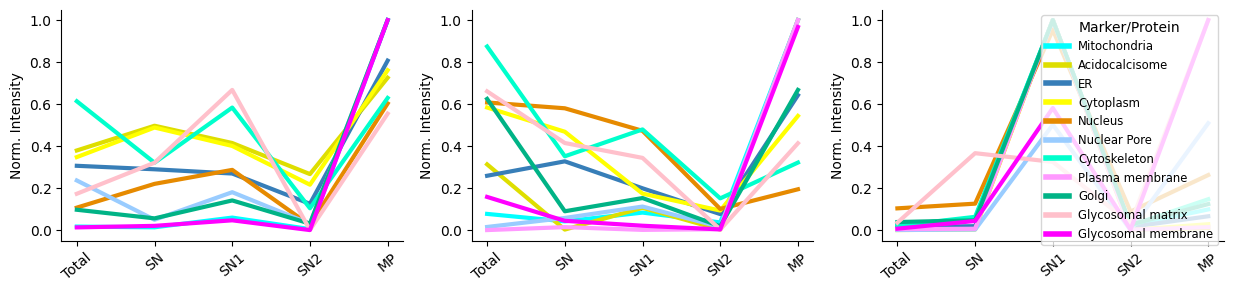

In [36]:
# Main plotting code
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

for marker, col in zip(moi, COLORS):
    ticks = ['Total', 'SN', 'SN1','SN2', 'MP']
    # Plotting traces for the first replicate
    vis.plot_traces(rep1[rep1['marker'] == marker], intCol1, ax=ax[0], plot_summary_only=True, summary_color=col, ylabel='Norm. Intensity')
    ax[0].set_xticks(range(len(intCol1)), labels=ticks, rotation=40)

    # Plotting traces for the second replicate
    vis.plot_traces(rep2[rep2['marker'] == marker], intCol2, ax=ax[1], plot_summary_only=True, summary_color=col, ylabel='Norm. Intensity')
    ax[1].set_xticks(range(len(intCol2)), labels=ticks, rotation=40)

    # Plotting traces for the third replicate
    vis.plot_traces(rep3[rep3['marker'] == marker], intCol3, ax=ax[2], plot_summary_only=True, summary_color=col, ylabel='Norm. Intensity')
    ax[2].set_xticks(range(len(intCol3)), labels=ticks, rotation=40)

# Adding the custom legend to the last subplot (or to whichever subplot is most appropriate)
create_custom_legend(moi, COLORS, ax[2])


### Visualizing all proteins in a marker list:

In [37]:
moi = ['Mitochondria','Acidocalcisome','ER', 'Cytoplasm','Nucleus','Nuclear Pore',
             'Cytoskeleton','Plasma membrane','Golgi', 'Glycosomal matrix', 'Glycosomal membrane']

In [38]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def create_custom_legend(moi, COLORS=None, ax=None):
    if COLORS is None:
        # Use the 'qualitative' 'Set1' color palette from matplotlib
        COLORS = plt.cm.Set1.colors[:len(moi)]

    # Create a list of Line2D objects for the legend
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for label, color in zip(moi, COLORS)]

    if ax is None:
        # If no axes object is provided, get the current axes
        ax = plt.gca()

    # Add the custom legend to the specified axes object
    ax.legend(handles=legend_elements, loc='best', fontsize='small', title="Marker/Protein")

    return ax

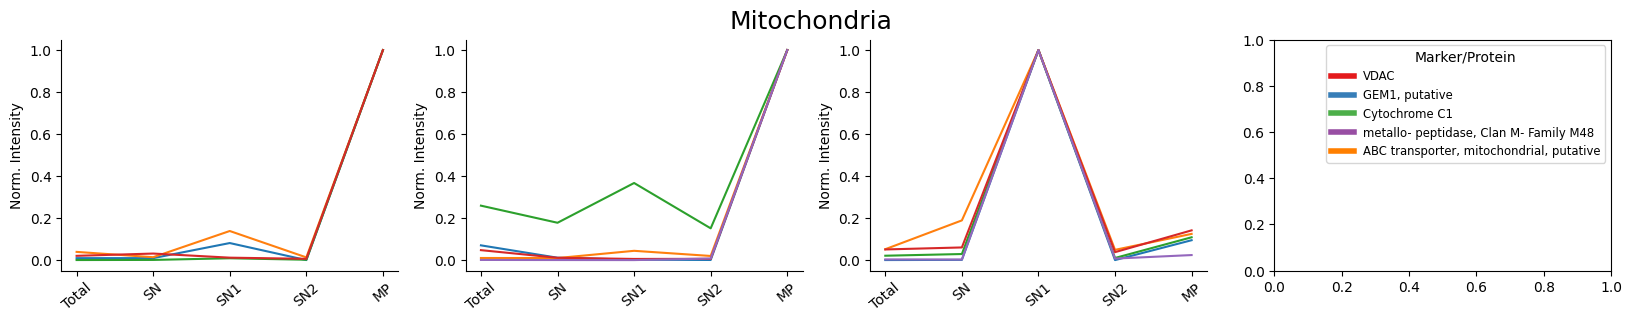

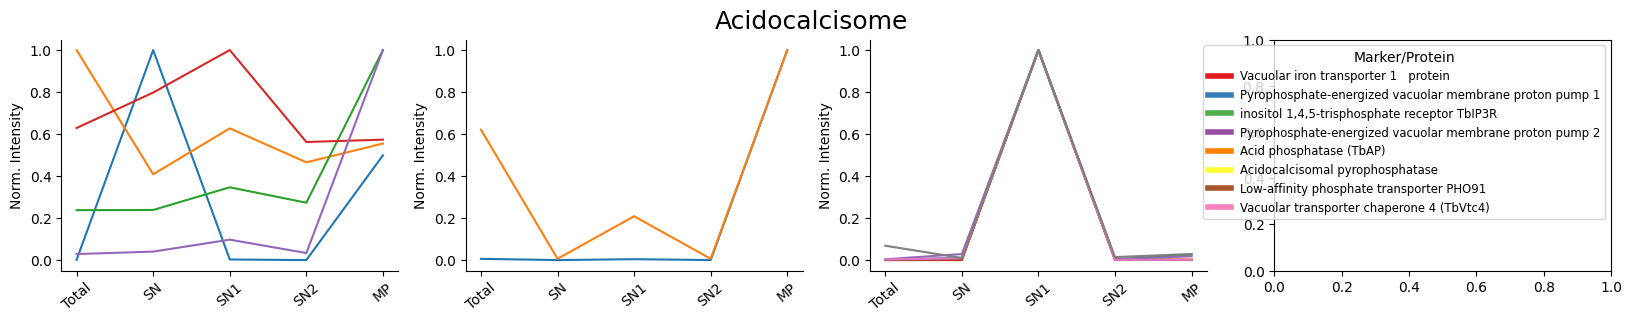

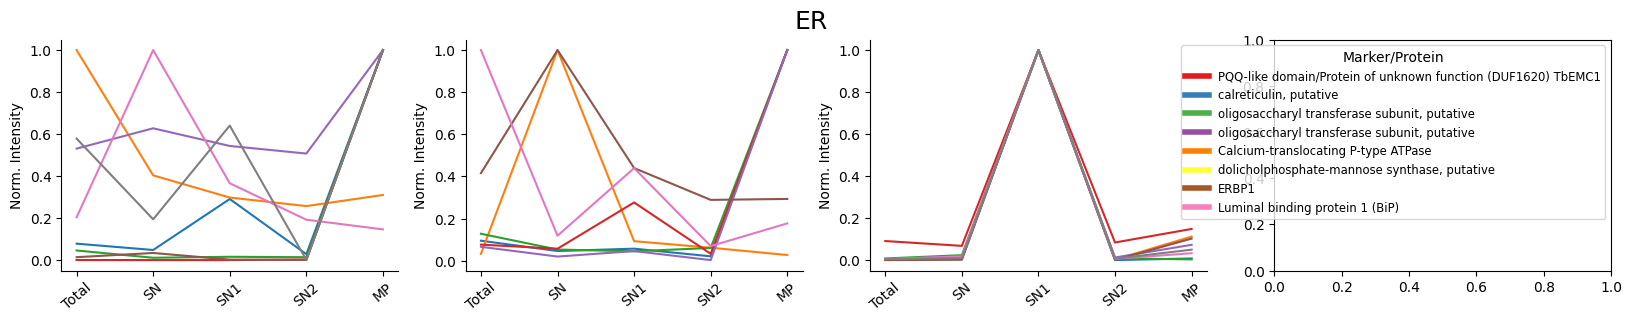

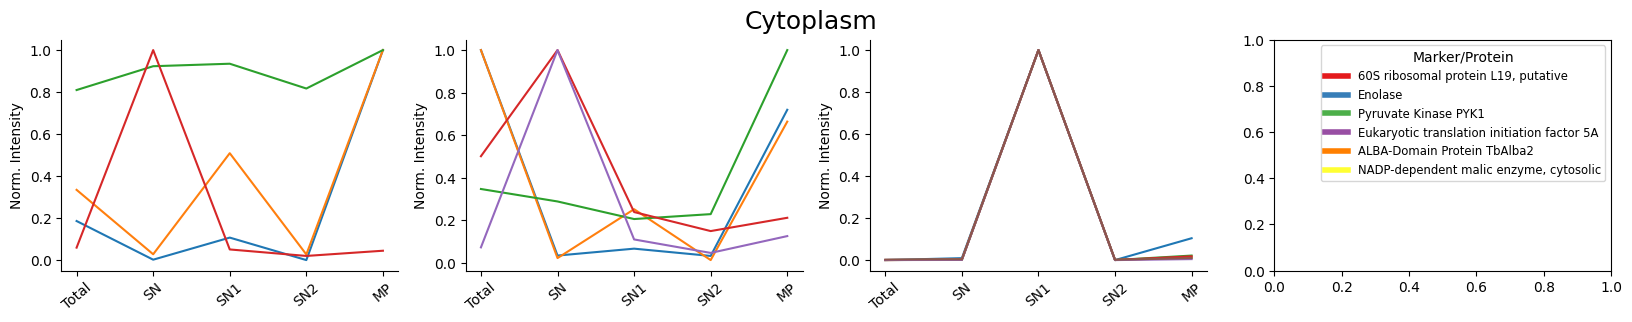

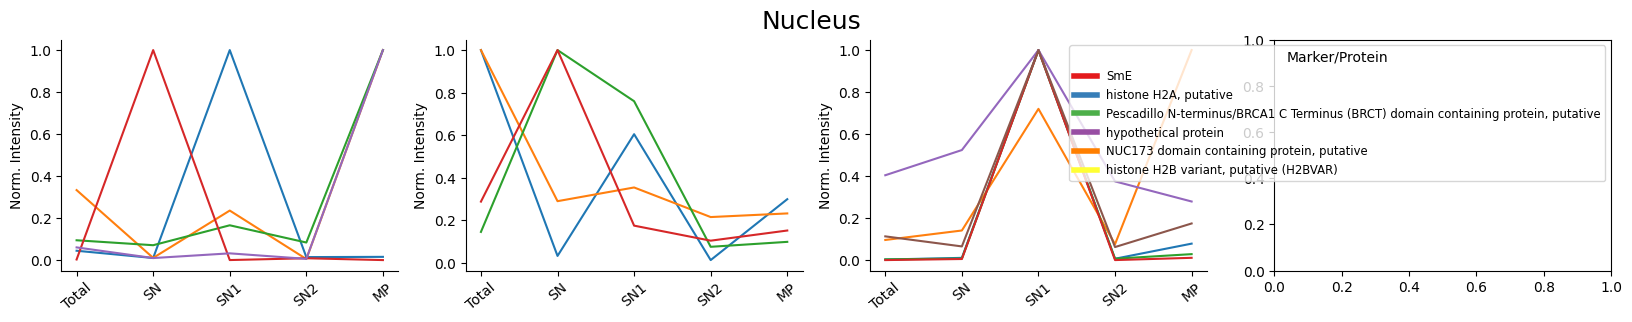

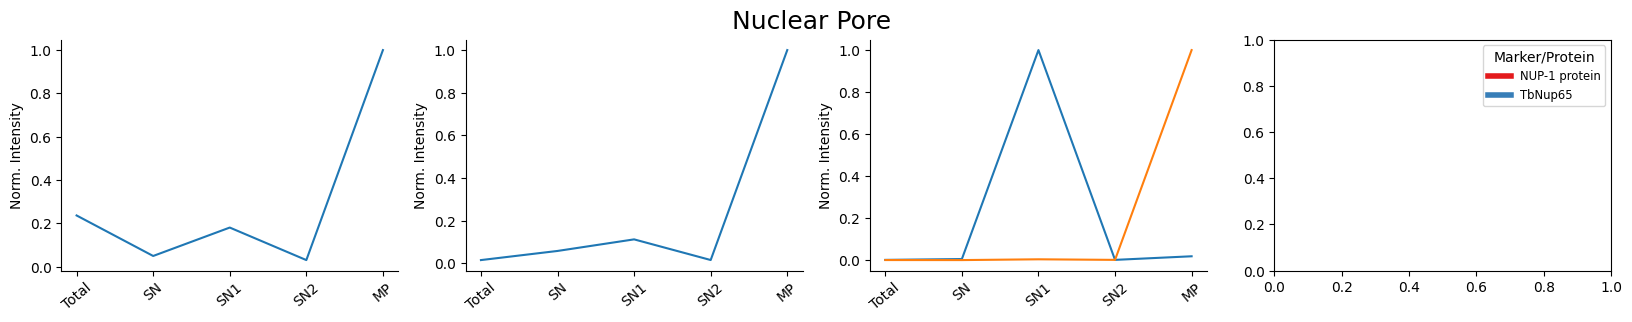

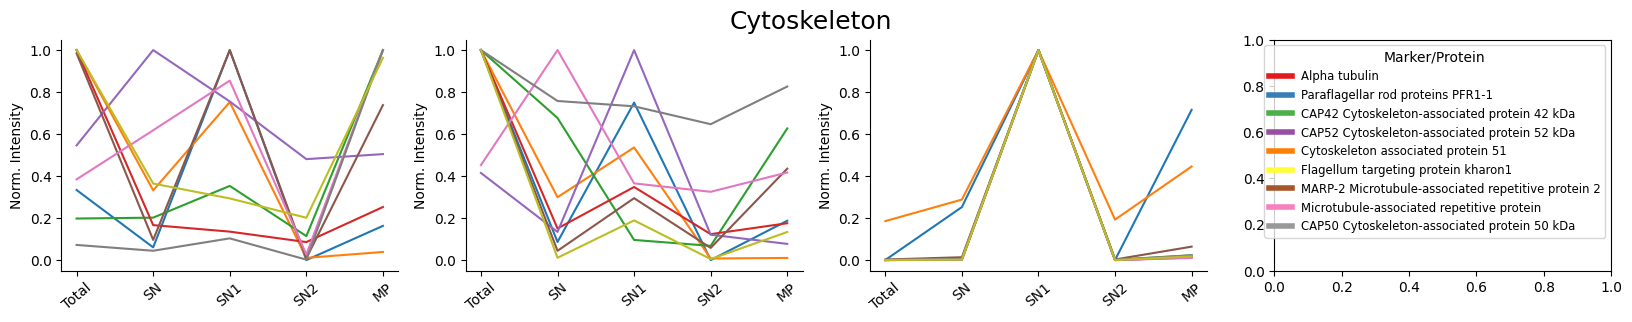

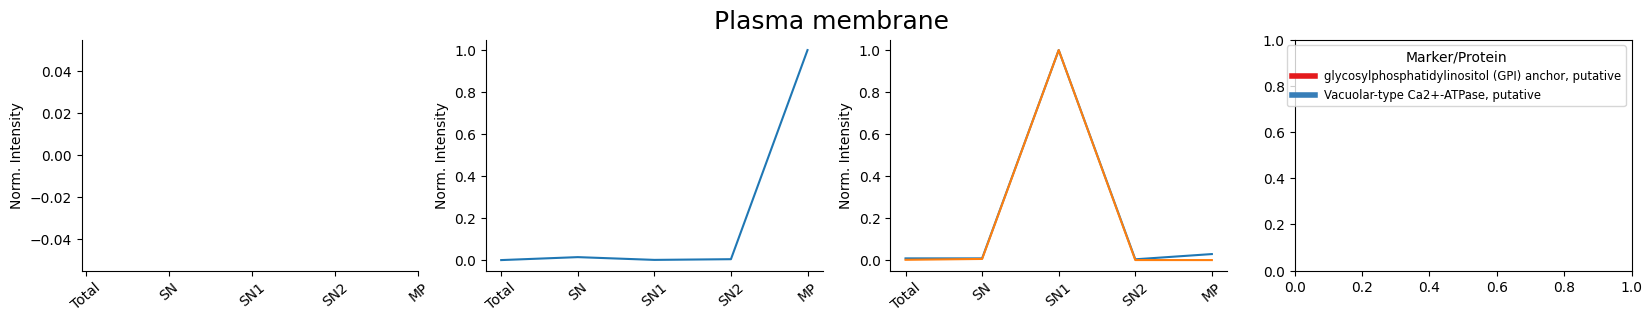

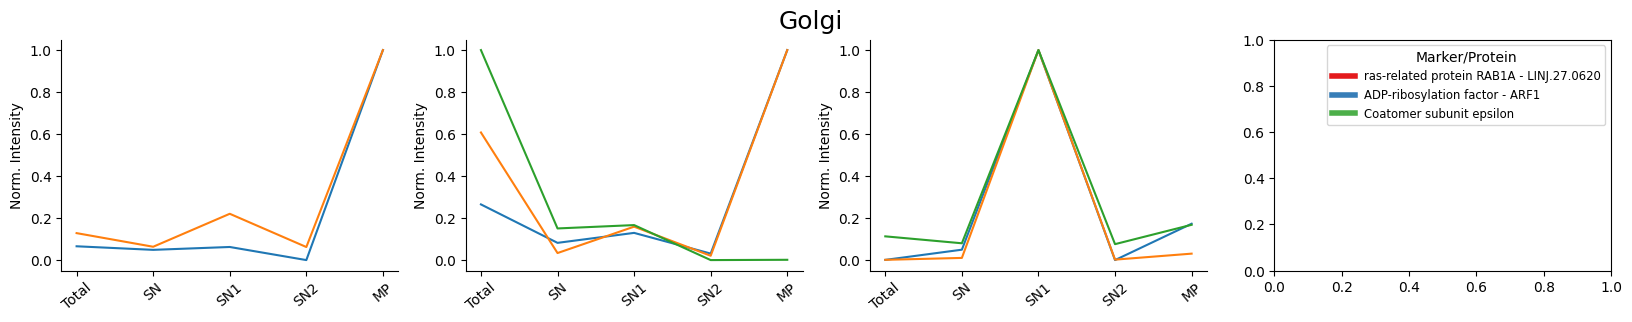

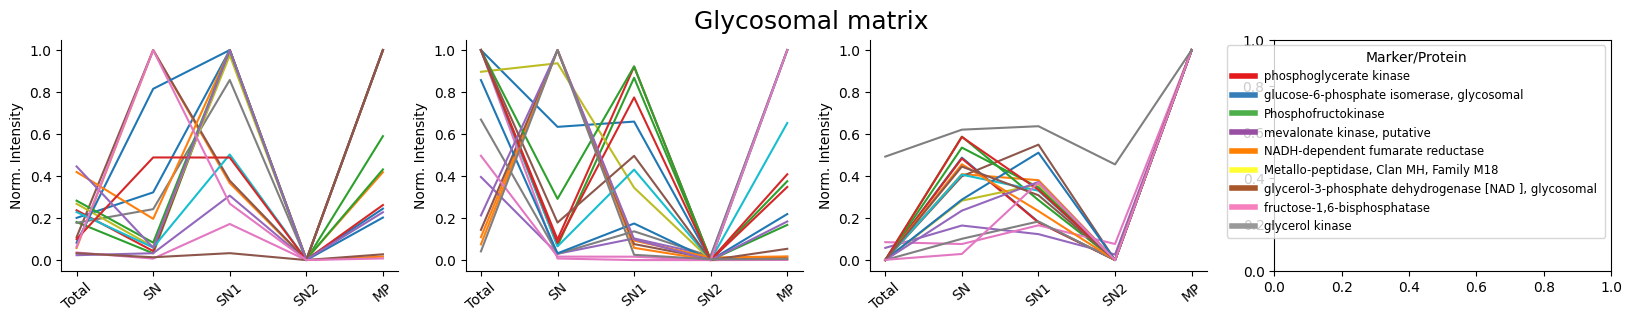

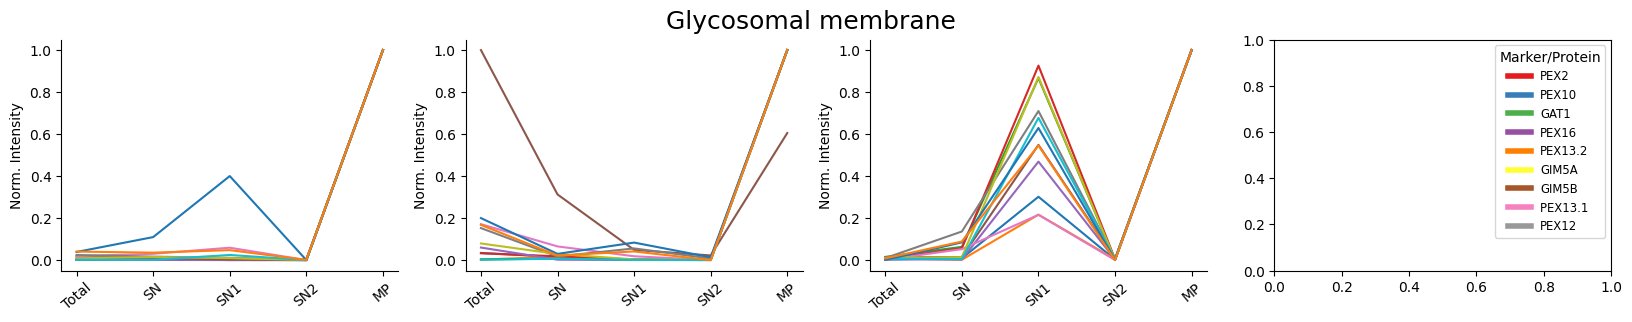

In [39]:
# Main plotting code
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

for m, col in zip(moi, COLORS):
    
        
    hlCol = COLORS[HUE_ORDER.index(marker)]

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,3))
    fig.suptitle(m, size=18)

    ticks = ['Total', 'SN', 'SN1','SN2', 'MP']

    # Plotting traces for the first replicate
    fig = vis.plot_traces(rep1[rep1['marker']==m], intCol1, ax=ax[0], plot_summary_only=False, summary_color=col, ylabel='Norm. Intensity')
    ax[0].set_xticks(range(len(intCol1)), labels=ticks, rotation=40)
    # create_custom_legend(rep1[rep1['marker'] == m]['Description'].to_list(), ax=ax[0])

    # Plotting traces for the second replicate
    fig = vis.plot_traces(rep2[rep2['marker']==m], intCol2, ax=ax[1], plot_summary_only=False, summary_color=col, ylabel='Norm. Intensity')
    ax[1].set_xticks(range(len(intCol2)), labels=ticks, rotation=40)
    # create_custom_legend(rep2[rep2['marker''marker'] == m]['Description'].to_list(), ax=ax[1])

    # Plotting traces for the third replicate
    fig = vis.plot_traces(rep3[rep3['marker']==m], intCol3, ax=ax[2], plot_summary_only=False, summary_color=col, ylabel='Norm. Intensity')
    ax[2].set_xticks(range(len(intCol3)), labels=ticks, rotation=40)
    create_custom_legend(rep3[rep3['marker'] == m]['Description'].to_list(), ax=ax[3])
        
        
# plt.savefig("results/marker_profile_plots" + ".pdf")


<Axes: >

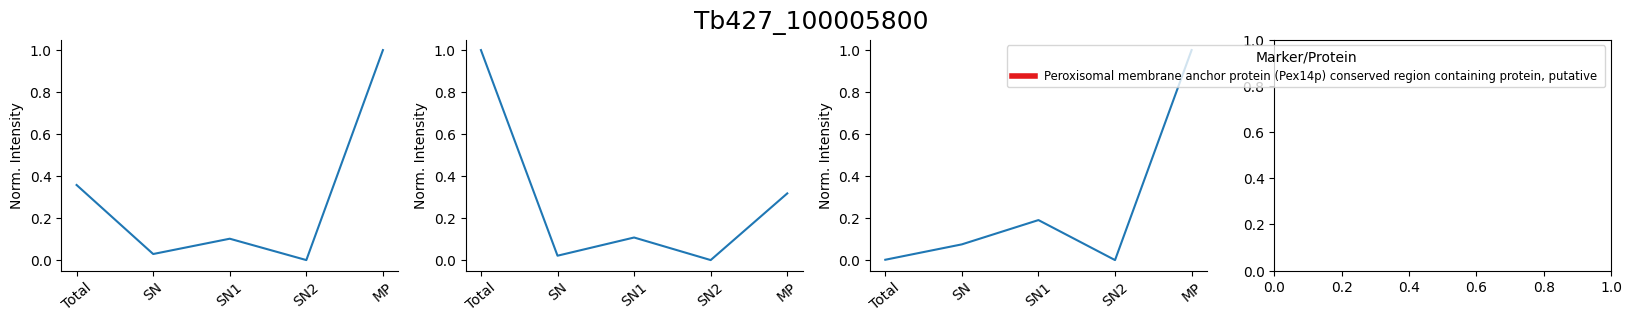

In [45]:
# Main plotting code
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

poi = 'Tb427_100005800'

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,3))
fig.suptitle(poi, size=18)

ticks = ['Total', 'SN', 'SN1','SN2', 'MP']

# Plotting traces for the first replicate
fig = vis.plot_traces(rep1[rep1['Majority protein IDs']==poi], intCol1, ax=ax[0], plot_summary_only=False, summary_color=col, ylabel='Norm. Intensity')
ax[0].set_xticks(range(len(intCol1)), labels=ticks, rotation=40)
# create_custom_legend(rep1[rep1['marker'] == m]['Description'].to_list(), ax=ax[0])

# Plotting traces for the second replicate
fig = vis.plot_traces(rep2[rep2['Majority protein IDs']==poi], intCol2, ax=ax[1], plot_summary_only=False, summary_color=col, ylabel='Norm. Intensity')
ax[1].set_xticks(range(len(intCol2)), labels=ticks, rotation=40)
# create_custom_legend(rep2[rep2['marker''marker'] == m]['Description'].to_list(), ax=ax[1])

# Plotting traces for the third replicate
fig = vis.plot_traces(rep3[rep3['Majority protein IDs']==poi], intCol3, ax=ax[2], plot_summary_only=False, summary_color=col, ylabel='Norm. Intensity')
ax[2].set_xticks(range(len(intCol3)), labels=ticks, rotation=40)
create_custom_legend(rep3[rep3['Majority protein IDs'] ==poi]['Fasta headers'].to_list(), ax=ax[3])

        
# plt.savefig("results/marker_profile_plots" + ".pdf")


## Merging all reps:

In [40]:
Rep1 = rep1[['id'] + rep1.filter(regex='log10_iBAQ Rep1').columns.to_list()]
Rep2 = rep2[['id'] + rep2.filter(regex='log10_iBAQ Rep2').columns.to_list()]
Rep3 = rep3[['id'] + rep3.filter(regex='log10_iBAQ Rep3').columns.to_list()]

In [41]:
Rep1['id'].duplicated().any()

False

In [42]:
df1 = df_marker.merge(Rep1, on='id', how='left')
df2 = df1.merge(Rep2, on='id', how='left')
df3 = df2.merge(Rep3, on='id', how='left')

In [43]:
intCol1

['log10_iBAQ Rep1_Total_Glycosome',
 'log10_iBAQ Rep1_SN0',
 'log10_iBAQ Rep1_SN1',
 'log10_iBAQ Rep1_SN2',
 'log10_iBAQ Rep1_MP']

In [44]:
df3.head(3)

Protein IDs  \
0                    Tb427_000013100;Tb427_000005600   
1  Tb427_000023800;Tb427_000012500;Tb427_00000820...   
2                                    Tb427_000012900   

                                Majority protein IDs Peptide counts (all)  \
0                    Tb427_000013100;Tb427_000005600                  2;2   
1  Tb427_000023800;Tb427_000012500;Tb427_00000820...        6;6;6;6;5;5;3   
2                                    Tb427_000012900                   16   

  Peptide counts (razor+unique) Peptide counts (unique)  \
0                           2;2                     1;1   
1                 1;1;1;1;1;1;1           1;1;1;1;1;1;1   
2                            16                      16   

                                       Fasta headers  Number of proteins  \
0  Trypanosome variant surface glycoprotein (A-ty...                   2   
1  BT1 family, putative ;BT1 family, putative ;BT...                   7   
2        Phosphotransferase enzyme family, putative                    1   

   Peptides  Razor + unique peptides  Unique peptides  ...  \
0         2                        2                1  ...   
1         6                        1                1  ...   
2        16                       16               16  ...   

   log10_iBAQ Rep2_Total_Glycosome  log10_iBAQ Rep2_SN0  log10_iBAQ Rep2_SN1  \
0                              NaN                  NaN                  NaN   
1                              NaN                  NaN                  NaN   
2                              1.0             0.201385             0.269744   

   log10_iBAQ Rep2_SN2  log10_iBAQ Rep2_MP  log10_iBAQ Rep3_Total_Glycosome  \
0                  NaN                 NaN                              NaN   
1                  NaN                 NaN                              NaN   
2             0.125403            0.536728                         0.006488   

   log10_iBAQ Rep3_SN0  log10_iBAQ Rep3_SN1  log10_iBAQ Rep3_SN2  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2             0.016169                  1.0             0.007779   

   log10_iBAQ Rep3_MP  
0                 NaN  
1                 NaN  
2            0.267876  

[3 rows x 316 columns]

## PCP of conditions:

In [48]:
from scipy.stats import pearsonr

def calcCorr(y1,y2):
    #center traces 
    y1 = [i-np.mean(y1) for i in y1]
    y2 = [i-np.mean(y2) for i in y2]
    return pearsonr(y1, y2)[0]


reps = [rep1, rep2, rep3]
ints = [intCol1, intCol2, intCol3]

dcorr1, dcorr2, dcorr3 = [], [], []
dcorrs = [dcorr1, dcorr2, dcorr3]

for rep, inte, pois, sim, dcorr in zip(reps, ints, poisIdx, maxSims, dcorrs):
    poxMean = rep.loc[rep["marker"]=='Glycosomal membrane',inte].mean(0)
    
    
    for i in range(rep.shape[0]):
        test = rep.iloc[i][inte].astype(float)

        poxSim = calcCorr(poxMean, test)
        dcorr.append(poxSim)

In [49]:
rep1["dcorr_Glyco-mem"] = dcorrs[0]
rep2["dcorr_Glyco-mem"] = dcorrs[1]
rep3["dcorr_Glyco-mem"] = dcorrs[2]

<Axes: >

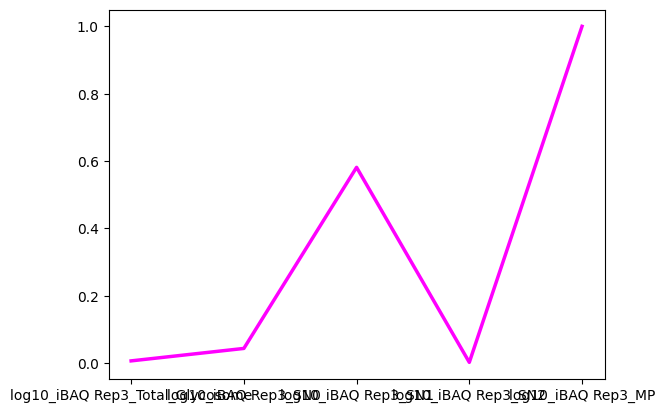

In [50]:
import seaborn as sns
sns.lineplot(data = poxMean.transpose(), linewidth=2.5, dashes =True, legend = 'auto', color="magenta")

<Axes: >

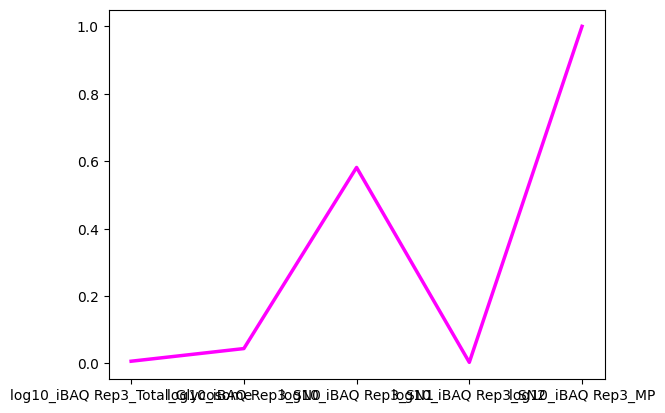

In [186]:
import seaborn as sns
sns.lineplot(data = poxMean.transpose(), linewidth=2.5, dashes =True, legend = 'auto', color="magenta")

Merging dataframes:

In [187]:
rep_1 =  rep1[['id','dcorr_Glyco-mem']]
rep_1 = rep_1.add_suffix("_Rep1")
df_merge1 = df3.merge(rep_1[['id_Rep1','dcorr_Glyco-mem_Rep1']], left_on='id',right_on='id_Rep1',how='left')

rep_2 =  rep2[['id','dcorr_Glyco-mem']]
rep_2 = rep_2.add_suffix("_Rep2")
df_merge2 = df_merge1.merge(rep_2[['id_Rep2','dcorr_Glyco-mem_Rep2']], left_on='id',right_on='id_Rep2',how='left')

rep_3 =  rep3[['id','dcorr_Glyco-mem']]
rep_3 = rep_3.add_suffix("_Rep3")
df_merge3 = df_merge2.merge(rep_3[['id_Rep3','dcorr_Glyco-mem_Rep3']], left_on='id',right_on='id_Rep3',how='left')

In [188]:
df_pcp = df_merge3.copy(deep=True)

In [189]:
corr_col = ['dcorr_Glyco-mem_Rep1', 'dcorr_Glyco-mem_Rep2', 'dcorr_Glyco-mem_Rep3']

In [190]:
df_pcp[corr_col]

dcorr_Glyco-mem_Rep1  dcorr_Glyco-mem_Rep2  dcorr_Glyco-mem_Rep3
0                      NaN                   NaN                   NaN
1                      NaN                   NaN                   NaN
2                 0.952094              0.307497              0.553614
3                      NaN                   NaN                   NaN
4                      NaN                   NaN                   NaN
...                    ...                   ...                   ...
4312                   NaN                   NaN                   NaN
4313              0.725904             -0.285157              0.396207
4314              0.966786              0.818769              0.332325
4315                   NaN                   NaN                   NaN
4316                   NaN                   NaN                   NaN

[4317 rows x 3 columns]

In [191]:
df_pcp = pp.filter_vv(df_pcp, [corr_col], n=2, valid_values=True)

4317 rows before filter operation.
2001 rows after filter operation.


In [192]:
df_pcp = pp.imp_seq(df_pcp, corr_col)

In [193]:
df_pcp.filter(regex='_imputed').columns

Index(['dcorr_Glyco mem_Rep1_imputed', 'dcorr_Glyco mem_Rep2_imputed',
       'dcorr_Glyco mem_Rep3_imputed'],
      dtype='object')

In [194]:
corr_col = ['dcorr_Glyco mem_Rep1_imputed', 'dcorr_Glyco mem_Rep2_imputed','dcorr_Glyco mem_Rep3_imputed']

## Rank-Product Test:

In [195]:
df_1 = ana.rank_prod(df_pcp, reps=['dcorr_Glyco-mem_Rep1', 'dcorr_Glyco-mem_Rep2', 'dcorr_Glyco-mem_Rep3'], cond='_Glyco-mem_PCP', correct_fc = True)

rankProd: Assuming a one sample test


## Interactive plots PCP Analysis 1: 

In [196]:
key = 'class1>class2_Glyco-mem_PCP'

In [197]:
list(df_pcp.columns)

['Protein IDs',
 'Majority protein IDs',
 'Peptide counts (all)',
 'Peptide counts (razor+unique)',
 'Peptide counts (unique)',
 'Fasta headers',
 'Number of proteins',
 'Peptides',
 'Razor + unique peptides',
 'Unique peptides',
 'Peptides Rep1_Density_F11',
 'Peptides Rep1_Density_F12',
 'Peptides Rep1_Density_F13',
 'Peptides Rep1_Density_F14',
 'Peptides Rep1_Density_F15',
 'Peptides Rep1_Density_F16',
 'Peptides Rep1_Density_F17',
 'Peptides Rep1_Density_F18',
 'Peptides Rep1_Density_F19',
 'Peptides Rep1_Density_F20',
 'Peptides Rep1_Density_F21',
 'Peptides Rep1_Density_F22',
 'Peptides Rep1_MP',
 'Peptides Rep1_SN0',
 'Peptides Rep1_SN1',
 'Peptides Rep1_SN2',
 'Peptides Rep1_Total_Glycosome',
 'Peptides Rep2_MP',
 'Peptides Rep2_OP',
 'Peptides Rep2_SN0',
 'Peptides Rep2_SN1',
 'Peptides Rep2_SN2',
 'Peptides Rep2_Total_Glycosome',
 'Peptides Rep3_Total_Glycosome',
 'Peptides Rep3_OP',
 'Peptides Rep3_SN1',
 'Peptides Rep3_SN0',
 'Peptides Rep3_SN2',
 'Peptides Rep3_MP',
 'Raz

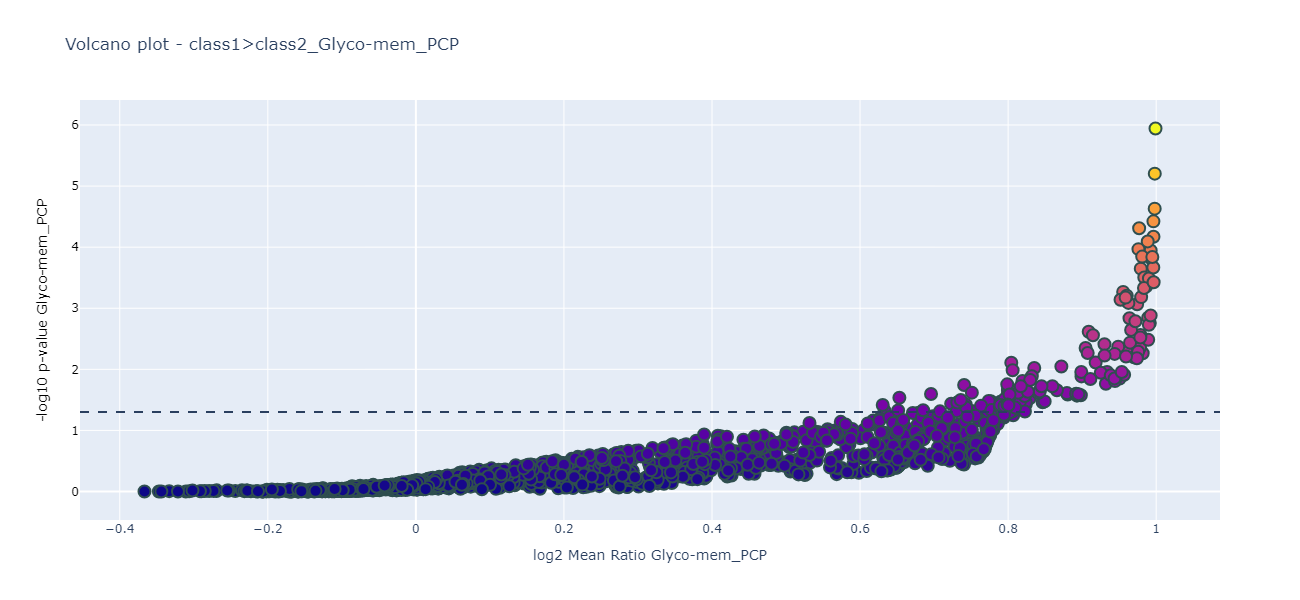

In [198]:
#### PLOTLY INTERACTIVE PLOT ####
key = 'class1>class2_Glyco-mem_PCP'
df_1['negative_PValue'] = np.log10(df_1['PValue_' + key]) * (-1)

fig = go.Figure()
trace1 = go.Scatter(
 x=df_1['logFC_Glyco-mem_PCP'],
 y=df_1['negative_PValue'],
 mode='markers',
    marker_color=df_1['negative_PValue'],
 hovertext = [
    f"{protein_ids.split(';')[0]}; {fasta_header1.split(';')[0]}"
    for protein_ids, fasta_header1 in zip(
        df_1["Majority protein IDs"],
        df_1["Fasta headers"].fillna('')
    )
]
)

fig.add_trace(trace1)
# fig.add_trace(trace2)
# fig.add_trace(trace3)
# fig.add_trace(trace4)
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.add_hline(y=1.3, line_dash="dash")
#fig.add_vline(x=1, line_dash="dash")
#fig.add_vline(x=-1, line_dash="dash")
fig.update_layout(title='Volcano plot - ' + key ,xaxis=dict(title="log2 Mean Ratio Glyco-mem_PCP"),
    yaxis=dict(title="-log10 p-value Glyco-mem_PCP"),
    autosize=False,
    width=800,  # Set the width of the figure
    height=600)  # Set the height of the figure)
#fig.update_layout(plot_bgcolor="white")
fig.update_yaxes(color='black', layer='above traces')

fig.show()
# fig.write_html(rootdir + r"/PCP_Glyco-membrane_v02.html")

## Volcano plots:

In [199]:
df_1['marker'].unique()

array([nan, 'Glyco_Cyto', 'Glycosomal matrix', 'Cytoskeleton',
       'Mitochondria', 'Nuclear Pore', 'Glyco_mito',
       'Glycosomal membrane', 'ER', 'Acidocalcisome', 'Nucleus',
       'Cytoplasm', 'Golgi', 'Plasma membrane'], dtype=object)

In [200]:
df_1["Majority protein IDs_1st"] = df_1["Majority protein IDs"].str.split(";").str.get(0)

In [201]:
COLORS = [ "cyan", "#dede00", "#377eb8", "#ffff00", "#e68a00", "#99ccff", 
          "#00ffcc", "#ff99ff", "#00b386","pink", "magenta"]


HUE_ORDER = ['Mitochondria','Acidocalcisome','ER', 'Cytoplasm','Nucleus','Nuclear Pore',
             'Cytoskeleton','Plasma membrane','Golgi', 'Glycosomal matrix', 'Glycosomal membrane']

(0.0, 1.02)

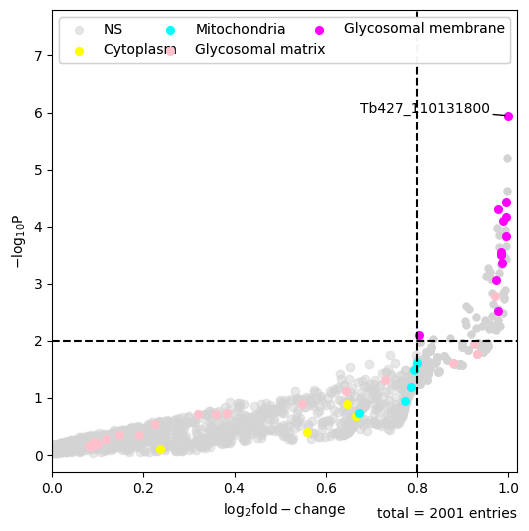

In [202]:
default_highlight_kwargs = {
    "marker": "o",  # set highlight shape to circle
    "s": 30,  # set highlight size to 100
    "alpha": 1,  # set highlight alpha to 0.8
}



fig = vis.volcano(df_1,log_fc_colname="logFC_Glyco-mem_PCP", 
            p_colname='PValue_class1>class2_Glyco-mem_PCP',
            p_thresh=0.01,log_fc_thresh = 0.8,
            annotate_colname = "Majority protein IDs_1st",
            figsize= (6, 6),
            annotate_density=10,
   highlight=[
        df_1[df_1['marker']=='Cytoplasm'].index,
        df_1[df_1['marker']=='Mitochondria'].index,
        df_1[df_1['marker']=='Glycosomal matrix'].index,
        df_1[df_1['marker']=='Glycosomal membrane'].index],
    annotate="highlight",
    kwargs_highlight=[
        default_highlight_kwargs
        | {
            "color": "yellow",  # set highlight color to red
            "label": "Cytoplasm",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "cyan",  # set highlight color to red
            "label": "Mitochondria",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "pink",  # set highlight color to red
            "label": "Glycosomal matrix",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "magenta",  # set highlight color to red
            "label": "Glycosomal membrane",  # set highlight label
        }],
    kwargs_both_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
        #      'edgecolors': '#58b3e8',    # set highlight edge colors to black
        "linewidths": 0.5,  # set highlight linewidths to 0.5
        "label": None,  # set highlight label
    },
    kwargs_log_fc_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
        "label": None,  # set highlight label
    },
    kwargs_p_sig={
        "color": "lightgrey",  # set highlight color to red
        "marker": "o",  # set highlight shape to circle
        "s": 30,  # set highlight size to 100
        "alpha": 1,  # set highlight alpha to 0.8
        # set highlight edge colors to black
        "linewidths": 0.5,  # set highlight linewidths to 0.5
        "label": None,  # set highlight label
    }    
    )
plt.xlim(0,1.02)
# plt.savefig(rootdir + '/VolcanoPlot_new_candidates.pdf')

(0.0, 1.02)

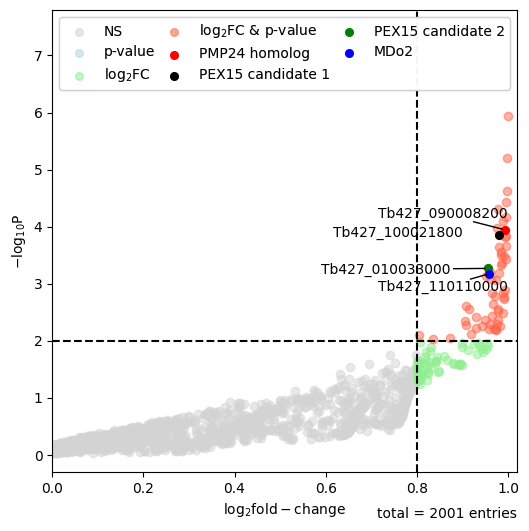

In [203]:
default_highlight_kwargs = {
    "marker": "o",  # set highlight shape to circle
    "s": 30,  # set highlight size to 100
    "alpha": 1,  # set highlight alpha to 0.8
}


fig = vis.volcano(df_1,log_fc_colname="logFC_Glyco-mem_PCP", 
            p_colname='PValue_class1>class2_Glyco-mem_PCP',
            p_thresh=0.01,log_fc_thresh = 0.8,
            annotate_colname = "Majority protein IDs_1st",
            figsize= (6, 6),
            annotate_density=100,
            highlight=[
        df_1.loc[df_1["Majority protein IDs"] == "Tb427_090008200"].index,
        df_1.loc[df_1["Majority protein IDs"] == "Tb427_100021800"].index,
        df_1.loc[df_1["Majority protein IDs"] == "Tb427_010033000"].index,
        df_1.loc[df_1["Majority protein IDs"] == "Tb427_110110000"].index],
    annotate="highlight",
    kwargs_highlight=[
        default_highlight_kwargs
        | {
            "color": "red",  # set highlight color to red
            "label": "PMP24 homolog",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "black",  # set highlight color to red
            "label": "PEX15 candidate 1",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "green",  # set highlight color to red
            "label": "PEX15 candidate 2",  # set highlight label
        },
        default_highlight_kwargs
        | {
            "color": "blue",  # set highlight color to red
            "label": "MDo2",  # set highlight label
        },
    ],
    )
plt.xlim(0,1.02)
# plt.savefig(rootdir + '/VolcanoPlot_new_candidates.pdf')

In [204]:
# list(df_1["Majority protein IDs"]+ '; ' +  df_1["Description"].fillna(''))

## Data export:

In [205]:
df_1.to_csv( "results/PCP_dataset1_combined.csv", index=False)

# Analysis 2: PCP of Density-gradient fractions:

## Selecting density-gradient rows:

In [206]:
df = df_marker.copy(deep=True)

In [207]:
ointCols = ['iBAQ Rep1_Density_F11', 'iBAQ Rep1_Density_F12',
       'iBAQ Rep1_Density_F13', 'iBAQ Rep1_Density_F14',
       'iBAQ Rep1_Density_F15', 'iBAQ Rep1_Density_F16',
       'iBAQ Rep1_Density_F17', 'iBAQ Rep1_Density_F18',
       'iBAQ Rep1_Density_F19', 'iBAQ Rep1_Density_F20',
       'iBAQ Rep1_Density_F21', 'iBAQ Rep1_Density_F22']

In [208]:
df[ointCols] = df[ointCols].replace(0, np.nan)

In [209]:
df2 = pp.remove_non_quant(df, ointCols)

4317 rows before filter operation.
4185 rows after filter operation.


In [210]:
df2, intCols = pp.log(df2, ointCols, base=10, return_cols=True)

In [211]:
df2["UID"] = range(1, df2.shape[0]+1)

Visualization of missing values:

True

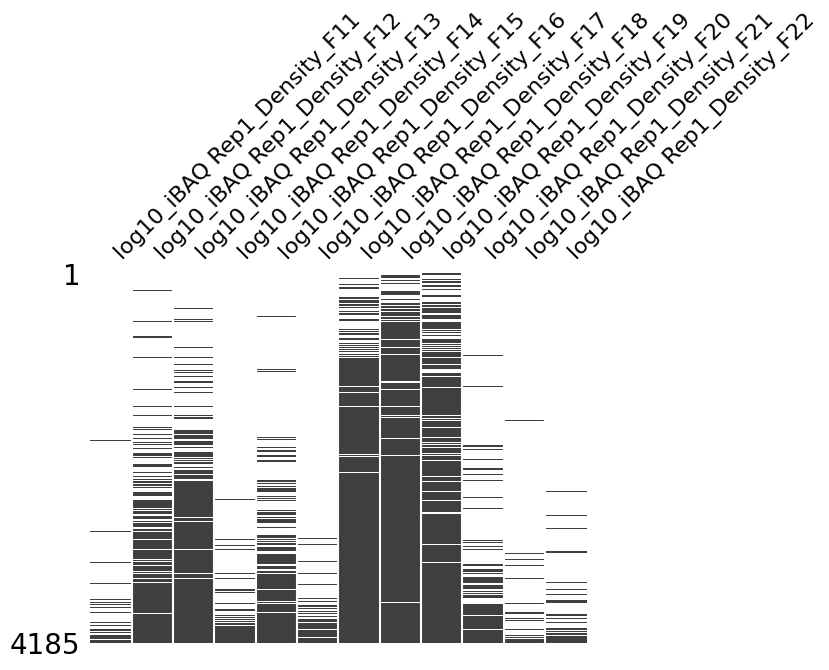

In [212]:
ana.miss_analysis(df2, intCols, text=False, vis=False, extra_vis=True, save_dir=None)

## PCP of density-fractions:

4185 rows before filter operation.
3853 rows after filter operation.


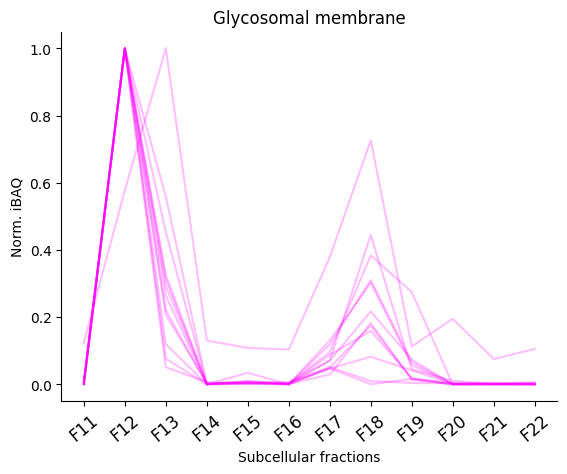

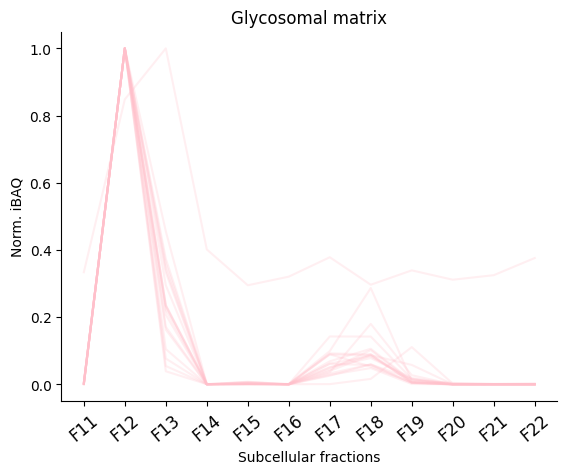

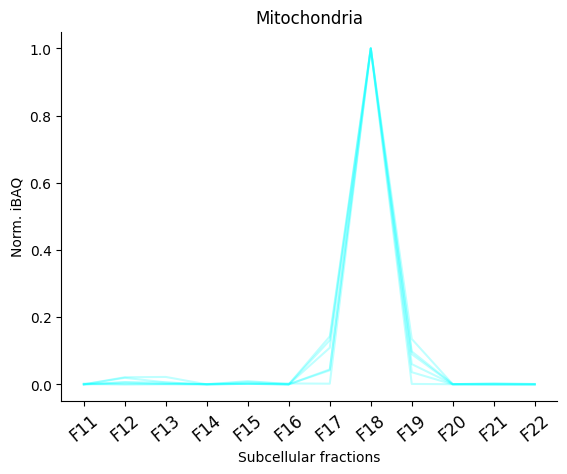

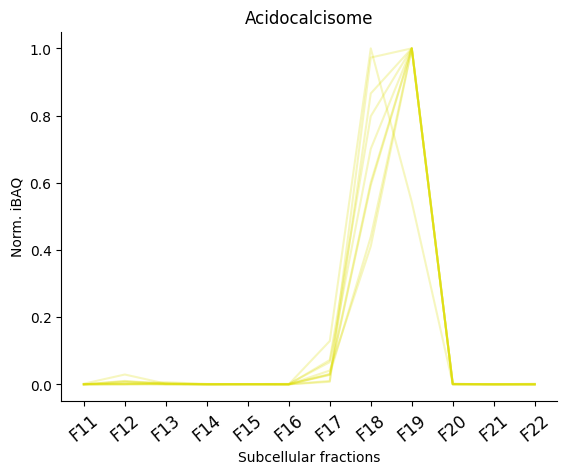

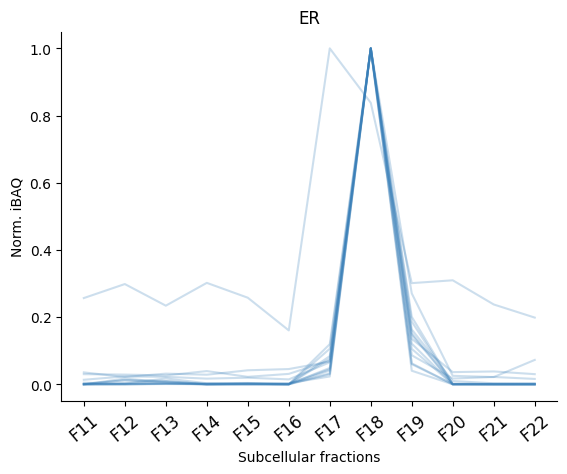

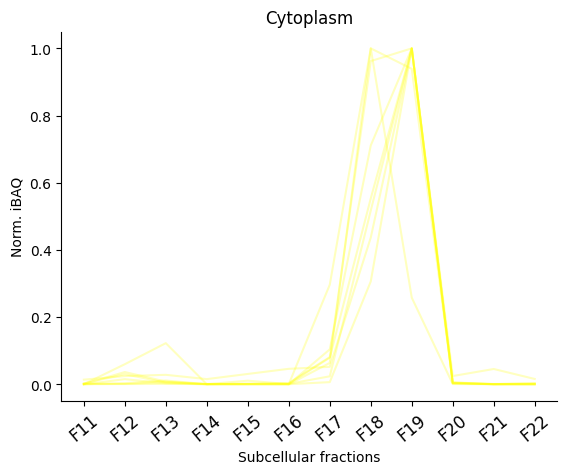

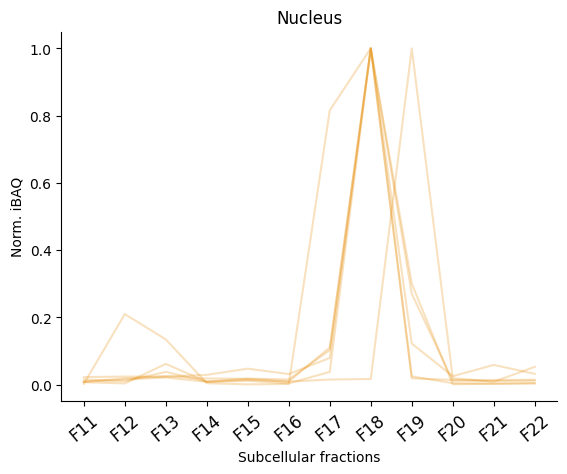

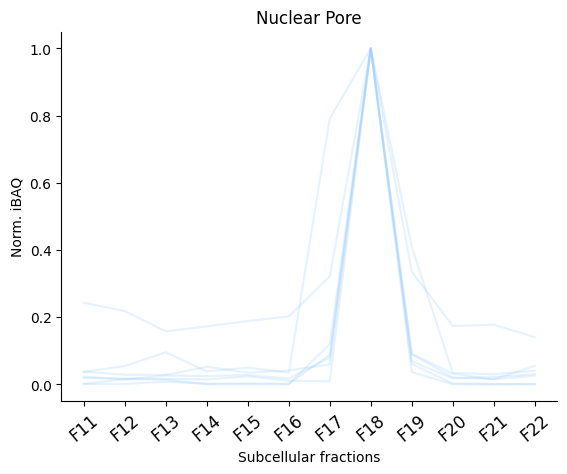

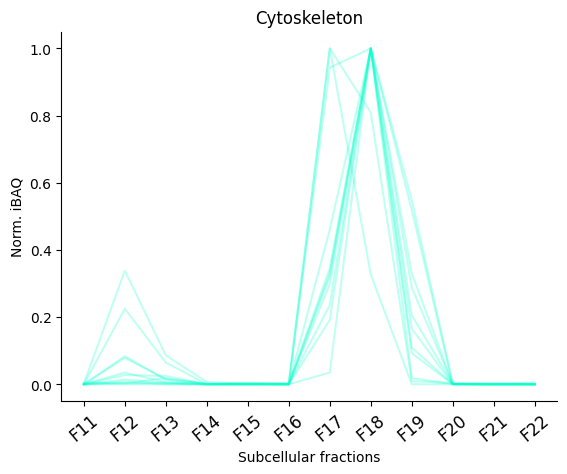

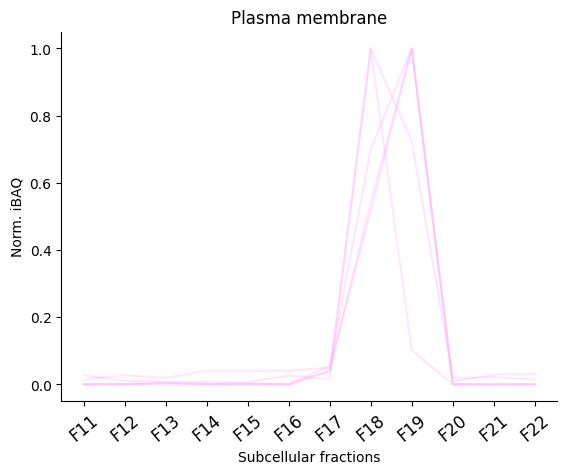

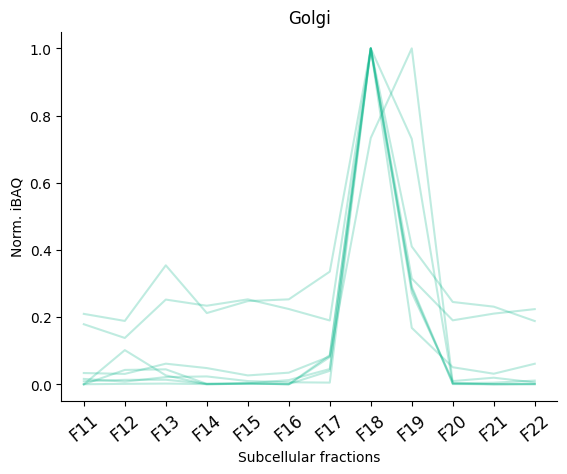

In [213]:
from sklearn.preprocessing import MinMaxScaler

intCol= intCols

df_filter = df2.copy(deep=True)
df_filter = pp.filter_vv(df_filter, [intCol], n=2, valid_values=True)

# df_filter[intCols1].to_csv(rootdir + "/data/rawIntCols_hd015.tsv", sep='\t', index=False)

def impute_per_row(row):

    downshift = 1.8
    width = .3

    var = np.std(row)
    mean = np.mean(row)

    mean_ = mean - downshift*var
    var_ = var*width

    #mean_ = 2
    #var_ = .3

    rnd = list(np.random.normal(mean_, var_, size=np.isnan(row).sum()))

    idx_noCtrl = row[row.isnull()].index

    for i, idx in enumerate(idx_noCtrl):
        row[idx] = rnd[i]

    return row

df_filter[intCol] = df_filter[intCol].apply(impute_per_row, axis=1)

df_norm2 = df_filter.copy(deep=True)

################  MIN-MAX NORMALIZATION ###############################
df_norm2[intCol] = 10**df_norm2[intCol]

df_norm2[intCol] = df_norm2[intCol].apply(lambda x: x/max(x), 1)

########Traces################

moi = ['Glycosomal membrane', 'Glycosomal matrix','Mitochondria','Acidocalcisome',
           'ER', 'Cytoplasm','Nucleus','Nuclear Pore','Cytoskeleton','Plasma membrane','Golgi']

for marker in moi:

    hlCol = COLORS[HUE_ORDER.index(marker)]

#         fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
#         plt.title(marker, size=18)
    forVis = df_norm2[df_norm2["marker"]==marker]

    
    ticks = ['F11','F12', 'F13','F14','F15','F16', 'F17','F18','F19', 'F20','F21','F22']
    
        
    vis.plot_traces(forVis,cols=intCol,  alpha=.25,
                   plot_summary=False,summary_type='Mean', title=marker, color=hlCol,ylabel= "Norm. iBAQ",  xlabel= "Subcellular fractions")
    plt.xticks(range(len(intCol)),labels=ticks, rotation=40,fontsize=12)
    
#     plt.savefig(rootdir + "/plots/Traces_Density_" + str(marker) + "_profile.pdf")
#     plt.title(marker)



    
#     vis.plotTraces(forVis,cols=intCol, alpha=1,title=marker,
#                    plotSummary=True, summaryColor=hlCol,ylabel= "Norm. Intensity")

    df_norm2.to_csv("results/dataset2_gradient"  + ".csv", index=False)

Reading saved data:

## Calculation of correlation:

In [214]:
rep1 = pp.read_csv("results/dataset2_gradient.csv", sep=',')

In [215]:
intCol1 = rep1.filter(regex='log10.*Density').columns.to_list()

In [216]:
intCol1

['log10_iBAQ Rep1_Density_F11',
 'log10_iBAQ Rep1_Density_F12',
 'log10_iBAQ Rep1_Density_F13',
 'log10_iBAQ Rep1_Density_F14',
 'log10_iBAQ Rep1_Density_F15',
 'log10_iBAQ Rep1_Density_F16',
 'log10_iBAQ Rep1_Density_F17',
 'log10_iBAQ Rep1_Density_F18',
 'log10_iBAQ Rep1_Density_F19',
 'log10_iBAQ Rep1_Density_F20',
 'log10_iBAQ Rep1_Density_F21',
 'log10_iBAQ Rep1_Density_F22']

In [217]:
from scipy.stats import pearsonr
from sklearn.metrics import auc
import numpy as np

def calcMagnitude(y1, y2):
    auca = auc(range(len(y1)), y1)
    aucb = auc(range(len(y2)), y2)
    mcomp = (auca - aucb) / (auca + aucb)
    return abs(mcomp)

def calcCorr(y1, y2):
    # center traces
    y1 = [i - np.mean(y1) for i in y1]
    y2 = [i - np.mean(y2) for i in y2]
    return pearsonr(y1, y2)[0]

def calcSim(y1, y2):
    pComp = calcCorr(y1, y2)
    mComp = calcMagnitude(y1, y2)
    if pComp < 0 and mComp < 0:
        return np.nan
    return -np.log10(pComp * mComp)

rep = rep1
inte = intCol1

poisIdx = []
sim = []
dcorr = []

poxMean = rep.loc[rep["marker"] == 'Glycosomal membrane', inte].mean(0)

for i in range(rep.shape[0]):
    test = rep.iloc[i][inte].astype(float)

    poxSim = calcCorr(poxMean, test)
    dcorr.append(poxSim)

    sims = [poxSim]
    sims = [i if ~np.isnan(i) else 0 for i in sims]

    if sum(sims) == 0:
        idx = -999
    else:
        try:
            idx = sims.index(max(sims))
        except:
            idx = -999

    if idx == 0:
        poisIdx.append(i)

    sim.append(idx)

In [218]:
rep1['dCorr_Density_gradient'] = dcorr

In [219]:
rep1.loc[(rep1['dCorr_Density_gradient']>0.90) & (rep1['marker'].str.contains('Gly'))][['Fasta headers', 'marker']]

Fasta headers               marker
63                   Phosphoglycerate kinase, putative     Glycosomal matrix
131                 Phosphoglucose isomerase, putative     Glycosomal matrix
347   Pex2 / Pex12 amino terminal region containing ...  Glycosomal membrane
350   Pex2 / Pex12 amino terminal region/Zinc finger...  Glycosomal membrane
383                      Phosphofructokinase, putative     Glycosomal matrix
675   ABC transporter transmembrane region 2/ABC tra...  Glycosomal membrane
676   GHMP kinases N terminal domain/GHMP kinases C ...    Glycosomal matrix
847   FAD binding domain/D-arabinono-1,4-lactone oxi...    Glycosomal matrix
1586  Peptidase family M20/M25/M40/Peptidase dimeris...    Glycosomal matrix
2009    Peroxisomal membrane protein (Pex16), putative   Glycosomal membrane
2064  Fructose-1-6-bisphosphatase, N-terminal domain...    Glycosomal matrix
2088                   hypothetical protein, conserved   Glycosomal membrane
2163  Peroxisomal biogenesis factor 11 (PEX11), puta...  Glycosomal membrane
2197  FGGY family of carbohydrate kinases, N-termina...    Glycosomal matrix
2360                              Hexokinase, putative     Glycosomal matrix
2361                              Hexokinase, putative     Glycosomal matrix
2383  Glucose-6-phosphate dehydrogenase, NAD binding...    Glycosomal matrix
2539  Fructose-bisphosphate aldolase class-I, putati...    Glycosomal matrix
2959                   hypothetical protein, conserved   Glycosomal membrane
2991  lactate/malate dehydrogenase, NAD binding doma...    Glycosomal matrix
3012  Pex2 / Pex12 amino terminal region containing ...  Glycosomal membrane
3059  Isocitrate/isopropylmalate dehydrogenase, puta...    Glycosomal matrix
3176  ABC transporter transmembrane region 2/ABC tra...  Glycosomal membrane
3290               Triosephosphate isomerase, putative     Glycosomal matrix
3326  Pyruvate phosphate dikinase, PEP/pyruvate bind...    Glycosomal matrix
3328  Glucosamine-6-phosphate isomerases/6-phosphogl...    Glycosomal matrix
3506  short chain dehydrogenase/Enoyl-(Acyl carrier ...           Glyco_mito
3525                   hypothetical protein, conserved   Glycosomal membrane
3595  Peroxisomal biogenesis factor 11 (PEX11), puta...  Glycosomal membrane

In [220]:
df2

Protein IDs  \
0                       Tb427_000013100;Tb427_000005600   
1     Tb427_000023800;Tb427_000012500;Tb427_00000820...   
2                                       Tb427_000012900   
3     Tb427_070082800;Tb427_000024800;Tb427_00002290...   
4                                       Tb427_000104800   
...                                                 ...   
4311                                    Tb427_110189200   
4312                                    Tb427_110189600   
4313                                    Tb427_110189700   
4314                                    Tb427_110189900   
4315                                    Tb427_110190000   

                                   Majority protein IDs Peptide counts (all)  \
0                       Tb427_000013100;Tb427_000005600                  2;2   
1     Tb427_000023800;Tb427_000012500;Tb427_00000820...        6;6;6;6;5;5;3   
2                                       Tb427_000012900                   16   
3     Tb427_070082800;Tb427_000024800;Tb427_00002290...          1;1;1;1;1;1   
4                                       Tb427_000104800                    2   
...                                                 ...                  ...   
4311                                    Tb427_110189200                   10   
4312                                    Tb427_110189600                    9   
4313                                    Tb427_110189700                    8   
4314                                    Tb427_110189900                   40   
4315                                    Tb427_110190000                    1   

     Peptide counts (razor+unique) Peptide counts (unique)  \
0                              2;2                     1;1   
1                    1;1;1;1;1;1;1           1;1;1;1;1;1;1   
2                               16                      16   
3                      1;1;1;1;1;1             1;1;1;1;1;1   
4                                2                       2   
...                            ...                     ...   
4311                            10                      10   
4312                             9                       9   
4313                             8                       8   
4314                            40                      40   
4315                             1                       1   

                                          Fasta headers  Number of proteins  \
0     Trypanosome variant surface glycoprotein (A-ty...                   2   
1     BT1 family, putative ;BT1 family, putative ;BT...                   7   
2           Phosphotransferase enzyme family, putative                    1   
3     hypothetical protein, conserved ;hypothetical ...                   6   
4     Trypanosome variant surface glycoprotein (A-ty...                   1   
...                                                 ...                 ...   
4311  ABC transporter transmembrane region/ABC trans...                   1   
4312        Calcineurin-like phosphoesterase, putative                    1   
4313          DnaJ domain containing protein, putative                    1   
4314  Leucine rich repeat/Leucine-rich repeat/Leucin...                   1   
4315       Rab5-interacting protein (Rab5ip), putative                    1   

      Peptides  Razor + unique peptides  Unique peptides  ...  \
0            2                        2                1  ...   
1            6                        1                1  ...   
2           16                       16               16  ...   
3            1                        1                1  ...   
4            2                        2                2  ...   
...        ...                      ...              ...  ...   
4311        10                       10               10  ...   
4312         9                        9                9  ...   
4313         8                        8                8  ...   
4314        40                

## Merging with Analysis1:

In [221]:
rep1[['id', 'dCorr_Density_gradient']+ intCol1]

id  dCorr_Density_gradient  log10_iBAQ Rep1_Density_F11  \
0      171                0.004963                     0.534704   
1      172               -0.108597                     0.007329   
2      175                0.105347                     0.001599   
3      176               -0.005322                     0.795292   
4      183                0.113818                     0.001194   
...    ...                     ...                          ...   
3848  4576                0.110378                     0.000522   
3849  4577               -0.006161                     0.060806   
3850  4578               -0.005317                     0.243226   
3851  4579                0.082565                     0.000043   
3852  4580                0.092337                     0.025921   

      log10_iBAQ Rep1_Density_F12  log10_iBAQ Rep1_Density_F13  \
0                        0.554243                     0.504340   
1                        0.009101                     0.007113   
2                        0.022042                     0.012062   
3                        0.786981                     0.777395   
4                        0.000367                     0.007951   
...                           ...                          ...   
3848                     0.000466                     0.000583   
3849                     0.059861                     0.082836   
3850                     0.338225                     0.270783   
3851                     0.002366                     0.003603   
3852                     0.024473                     0.033842   

      log10_iBAQ Rep1_Density_F14  log10_iBAQ Rep1_Density_F15  \
0                        0.492243                     0.571154   
1                        0.023714                     0.029196   
2                        0.000757                     0.001544   
3                        0.811427                     0.778466   
4                        0.001012                     0.000888   
...                           ...                          ...   
3848                     0.000427                     0.001531   
3849                     0.059098                     0.050356   
3850                     0.316238                     0.267134   
3851                     0.000138                     0.000547   
3852                     0.028945                     0.024887   

      log10_iBAQ Rep1_Density_F16  log10_iBAQ Rep1_Density_F17  \
0                        0.489858                     0.520574   
1                        0.007461                     0.042099   
2                        0.000778                     0.123080   
3                        0.799617                     0.773511   
4                        0.001656                     0.008744   
...                           ...                          ...   
3848                     0.000376                     0.029597   
3849                     0.050011                     0.083734   
3850                     0.306038                     1.000000   
3851                     0.000024                     0.251074   
3852                     0.023056                     0.062905   

      log10_iBAQ Rep1_Density_F18  log10_iBAQ Rep1_Density_F19  \
0                        0.618957                     1.000000   
1                        0.012805                     1.000000   
2                        1.000000                     0.242648   
3                        1.000000                     0.846019   
4                        1.000000                     0.012831   
...                           ...                          ...   
3848                     1.000000                     0.028116   
3849                     0.728792                     1.000000   
3850                     0.485924                     0.421821   
3851                     1.000000                     0.199759   
3852                     1.000000                     0.202198   

      log10_iBAQ Rep1_Density_F

In [222]:
df_2 = df_main.merge(rep1[['id', 'dCorr_Density_gradient']+ intCol1], on='id', how='left')

In [223]:
df_2

Protein IDs  \
0                       Tb427_000013100;Tb427_000005600   
1     Tb427_000023800;Tb427_000012500;Tb427_00000820...   
2                                       Tb427_000012900   
3     Tb427_070082800;Tb427_000024800;Tb427_00002290...   
4                                       Tb427_000104800   
...                                                 ...   
4312                                    Tb427_110189600   
4313                                    Tb427_110189700   
4314                                    Tb427_110189900   
4315                                    Tb427_110190000   
4316                                    Tb427_110190100   

                                   Majority protein IDs Peptide counts (all)  \
0                       Tb427_000013100;Tb427_000005600                  2;2   
1     Tb427_000023800;Tb427_000012500;Tb427_00000820...        6;6;6;6;5;5;3   
2                                       Tb427_000012900                   16   
3     Tb427_070082800;Tb427_000024800;Tb427_00002290...          1;1;1;1;1;1   
4                                       Tb427_000104800                    2   
...                                                 ...                  ...   
4312                                    Tb427_110189600                    9   
4313                                    Tb427_110189700                    8   
4314                                    Tb427_110189900                   40   
4315                                    Tb427_110190000                    1   
4316                                    Tb427_110190100                    2   

     Peptide counts (razor+unique) Peptide counts (unique)  \
0                              2;2                     1;1   
1                    1;1;1;1;1;1;1           1;1;1;1;1;1;1   
2                               16                      16   
3                      1;1;1;1;1;1             1;1;1;1;1;1   
4                                2                       2   
...                            ...                     ...   
4312                             9                       9   
4313                             8                       8   
4314                            40                      40   
4315                             1                       1   
4316                             2                       2   

                                          Fasta headers  Number of proteins  \
0     Trypanosome variant surface glycoprotein (A-ty...                   2   
1     BT1 family, putative ;BT1 family, putative ;BT...                   7   
2           Phosphotransferase enzyme family, putative                    1   
3     hypothetical protein, conserved ;hypothetical ...                   6   
4     Trypanosome variant surface glycoprotein (A-ty...                   1   
...                                                 ...                 ...   
4312        Calcineurin-like phosphoesterase, putative                    1   
4313          DnaJ domain containing protein, putative                    1   
4314  Leucine rich repeat/Leucine-rich repeat/Leucin...                   1   
4315       Rab5-interacting protein (Rab5ip), putative                    1   
4316        Cytochrome oxidase c subunit VIb, putative                    1   

      Peptides  Razor + unique peptides  Unique peptides  ...  \
0            2                        2                1  ...   
1            6                        1                1  ...   
2           16                       16               16  ...   
3            1                        1                1  ...   
4            2                        2                2  ...   
...        ...                      ...              ...  ...   
4312         9                        9                9  ...   
4313         8                        8                8  ...   
4314        40                       40               40  ...   
4315         1                

## Data export:

In [224]:
rep1.to_csv("results/PCP_dataset2_combined.csv", index=False)

# Final export:

 Dropping columns not required:

In [225]:
notcols = df_2.filter(regex='class1<class2_').columns.to_list()
df_2 = df_2.drop(columns=notcols)

In [226]:
df_2["Majority protein IDs_1st"] = df_2["Majority protein IDs"].str.split(";").str.get(0)

In [227]:
merge1 = pd.merge(df_main, df_1,how="left", on ='id', suffixes=('', '_y'))
merge1.drop(merge1.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [228]:
merge2 = pd.merge(merge1, df_2,how="left", on ='id', suffixes=('', '_y'))
merge2.drop(merge2.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [229]:
merge2.head(2)

Protein IDs  \
0                    Tb427_000013100;Tb427_000005600   
1  Tb427_000023800;Tb427_000012500;Tb427_00000820...   

                                Majority protein IDs Peptide counts (all)  \
0                    Tb427_000013100;Tb427_000005600                  2;2   
1  Tb427_000023800;Tb427_000012500;Tb427_00000820...        6;6;6;6;5;5;3   

  Peptide counts (razor+unique) Peptide counts (unique)  \
0                           2;2                     1;1   
1                 1;1;1;1;1;1;1           1;1;1;1;1;1;1   

                                       Fasta headers  Number of proteins  \
0  Trypanosome variant surface glycoprotein (A-ty...                   2   
1  BT1 family, putative ;BT1 family, putative ;BT...                   7   

   Peptides  Razor + unique peptides  Unique peptides  ...  \
0         2                        2                1  ...   
1         6                        1                1  ...   

   log10_iBAQ Rep1_Density_F13  log10_iBAQ Rep1_Density_F14  \
0                     0.504340                     0.492243   
1                     0.007113                     0.023714   

   log10_iBAQ Rep1_Density_F15  log10_iBAQ Rep1_Density_F16  \
0                     0.571154                     0.489858   
1                     0.029196                     0.007461   

   log10_iBAQ Rep1_Density_F17  log10_iBAQ Rep1_Density_F18  \
0                     0.520574                     0.618957   
1                     0.042099                     0.012805   

   log10_iBAQ Rep1_Density_F19  log10_iBAQ Rep1_Density_F20  \
0                          1.0                     0.448712   
1                          1.0                     0.014603   

   log10_iBAQ Rep1_Density_F21  log10_iBAQ Rep1_Density_F22  
0                     0.500431                     0.537568  
1                     0.016132                     0.011395  

[2 rows x 346 columns]

In [230]:
notcols = merge2.filter(regex='class1<class2_').columns.to_list()
merge2 = merge2.drop(columns=notcols)

In [231]:
merge2.to_excel("results/Results_Tb_membrane_protein_inventory.xlsx", index=False)

In [232]:
merge2.to_csv("results/Results_Tb_membrane_protein_inventory.csv", index=False)

# Plotting to test data:

<Axes: >

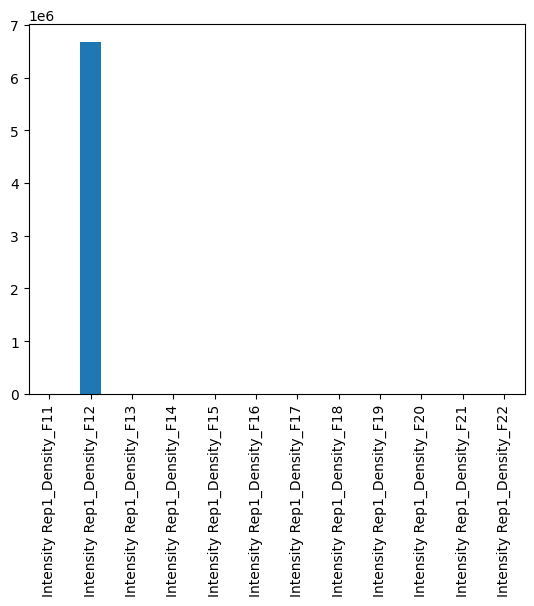

In [302]:
merge2[(merge2['Majority protein IDs']=='Tb427_100067300')].filter(regex='^Intensity.*_Density').mean().plot(kind='bar')

In [294]:
poi = merge2[(merge2['logFC_Glyco-mem_PCP']>0.80) & (merge2['PValue_class1>class2_Glyco-mem_PCP']>0.01) & (merge2['PValue_class1>class2_Glyco-mem_PCP']<0.05)]['Majority protein IDs']

In [292]:
poi = merge2[(merge2['logFC_Glyco-mem_PCP']>0.80) & (merge2['PValue_class1>class2_Glyco-mem_PCP']<0.01)]['Majority protein IDs']

In [ ]:
COLORS = [ "cyan", "#dede00", "#377eb8", "#ffff00", "#e68a00", "#99ccff", 
          "#00ffcc", "#ff99ff", "#00b386","pink", "magenta"]


HUE_ORDER = ['Mitochondria','Acidocalcisome','ER', 'Cytoplasm','Nucleus','Nuclear Pore',
             'Cytoskeleton','Plasma membrane','Golgi', 'Glycosomal matrix', 'Glycosomal membrane']

In [ ]:
moi = ['Mitochondria','Acidocalcisome','ER', 'Cytoplasm','Nucleus','Nuclear Pore',
             'Cytoskeleton','Plasma membrane','Golgi', 'Glycosomal matrix', 'Glycosomal membrane']

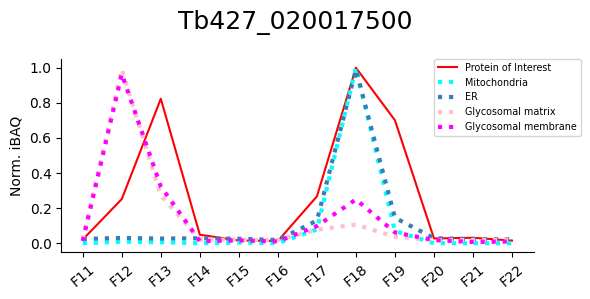

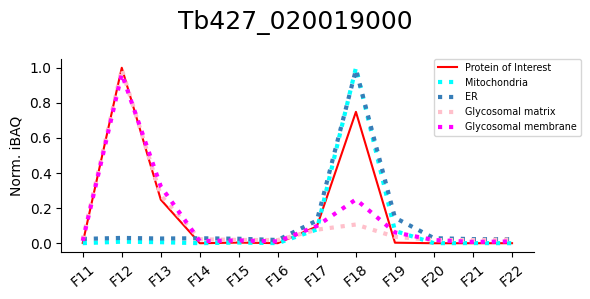

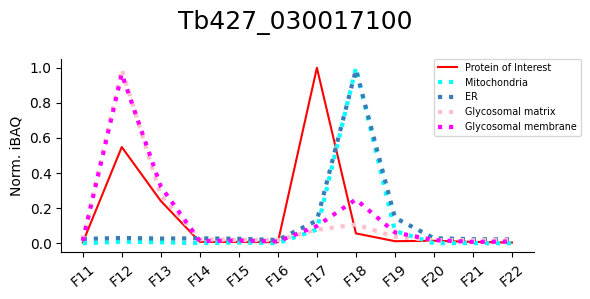

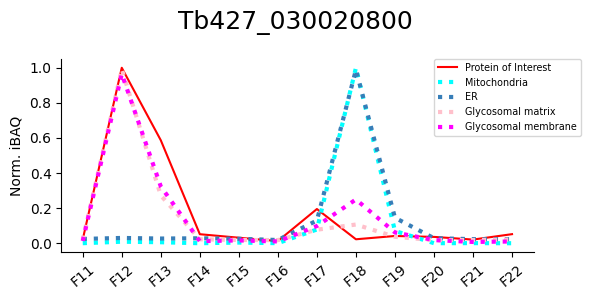

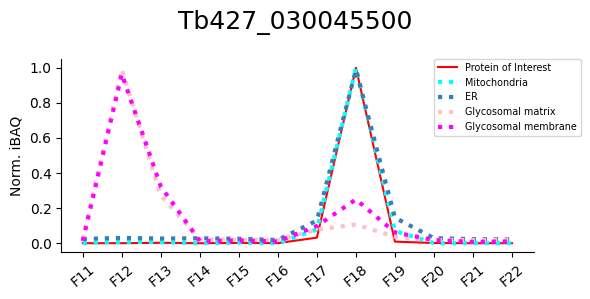

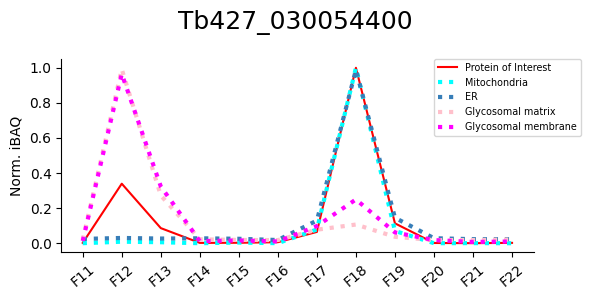

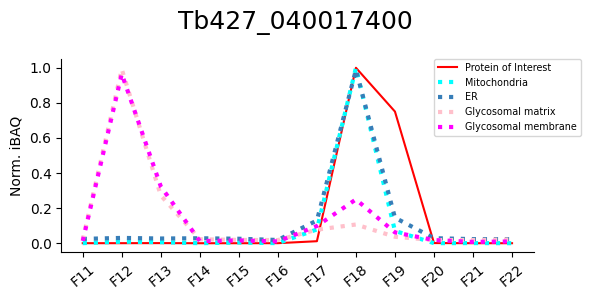

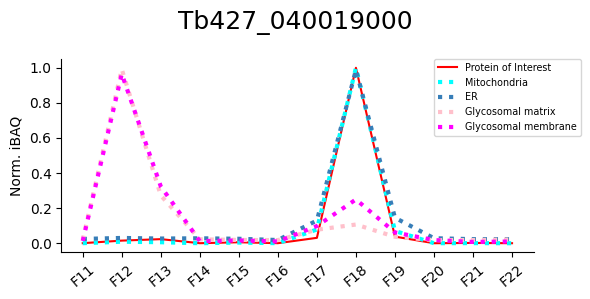

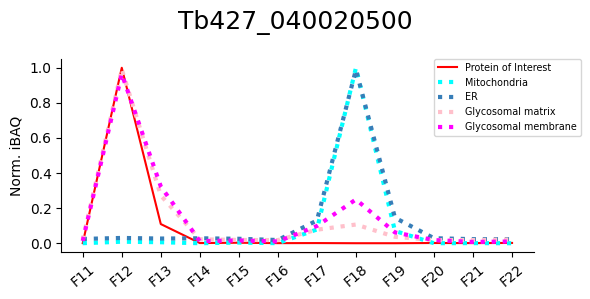

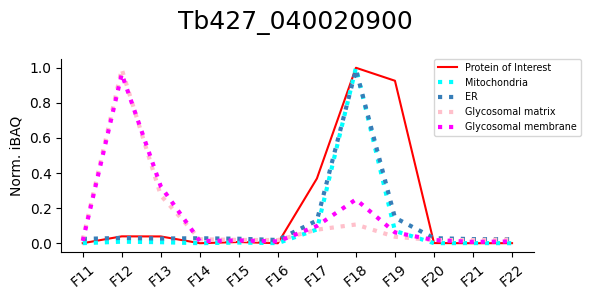

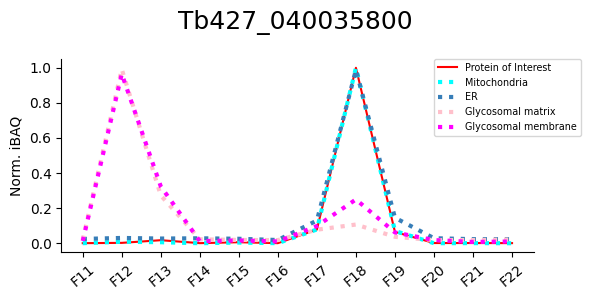

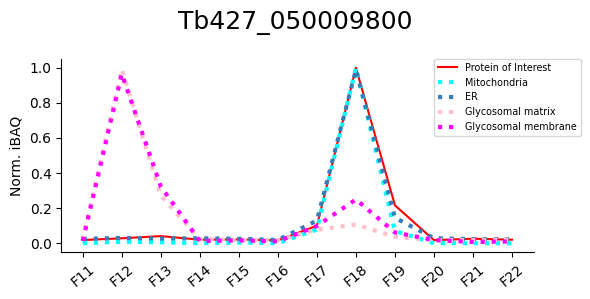

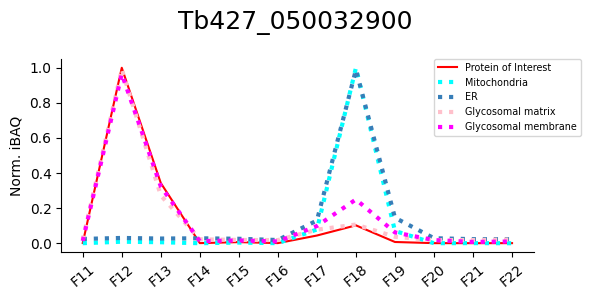

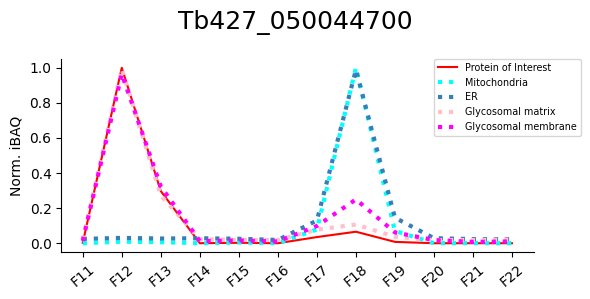

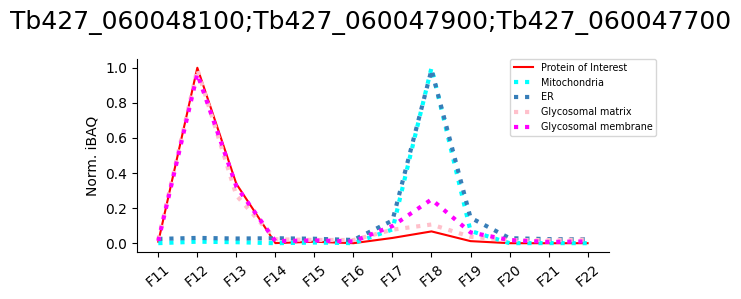

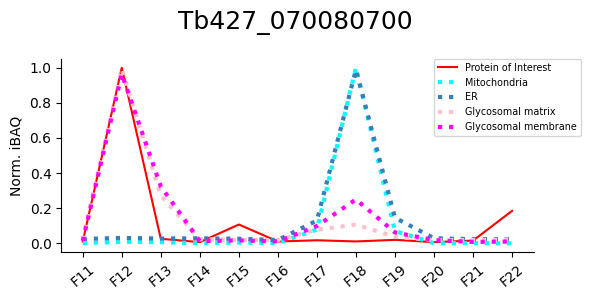

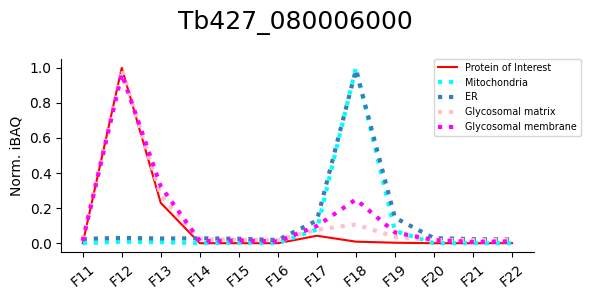

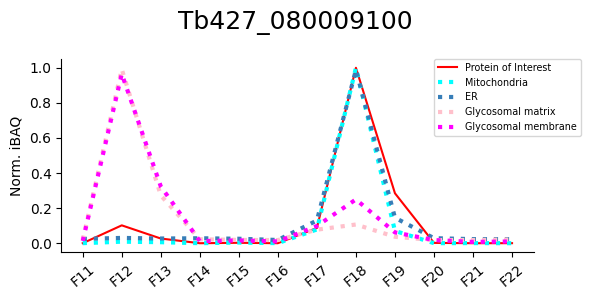

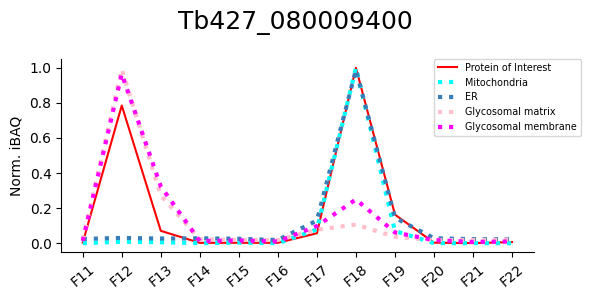

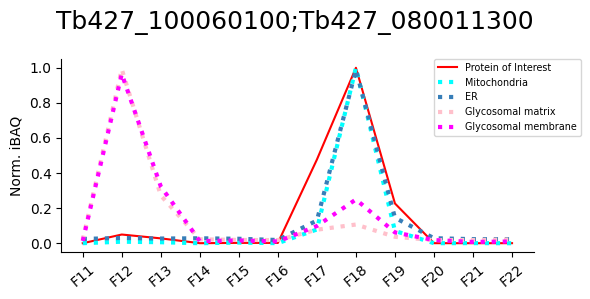

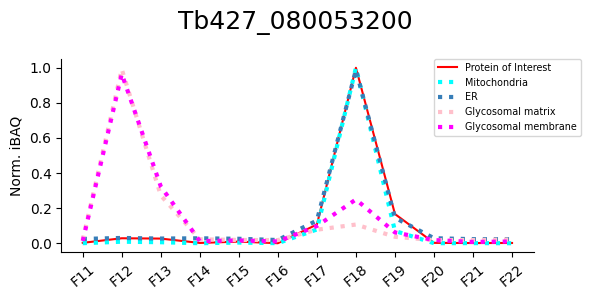

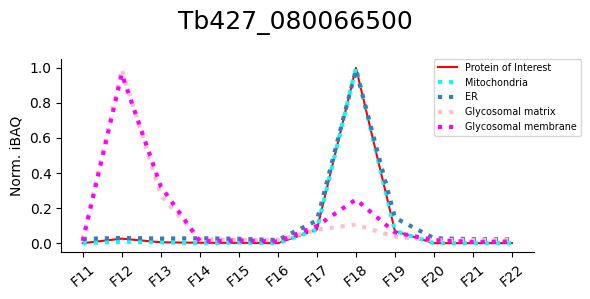

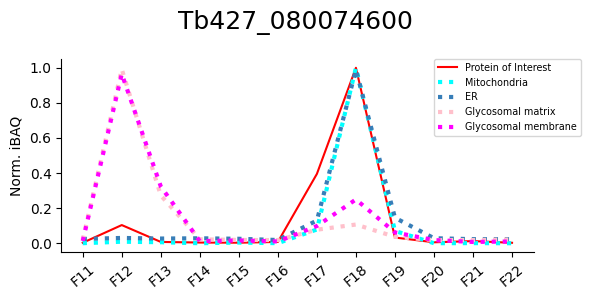

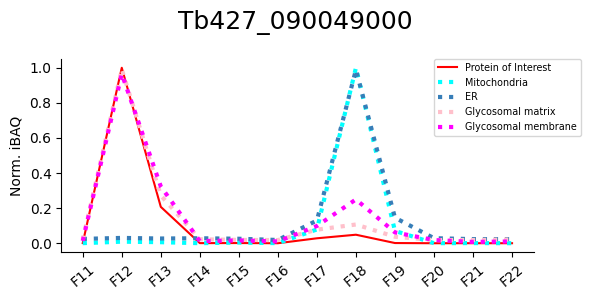

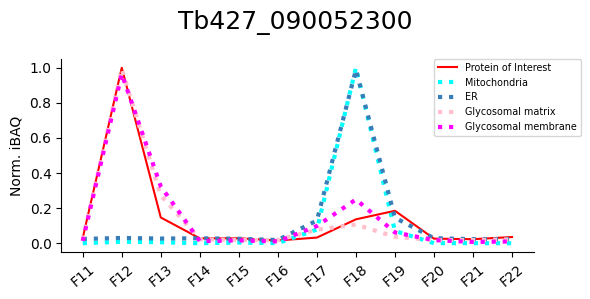

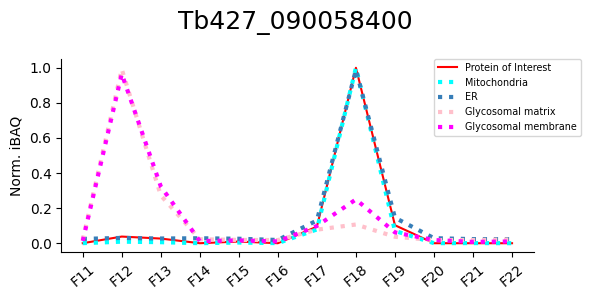

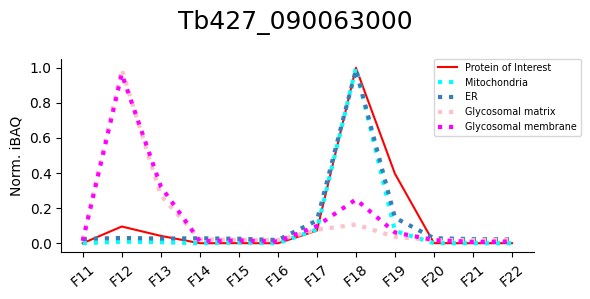

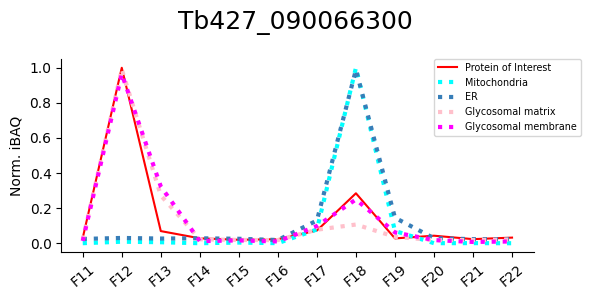

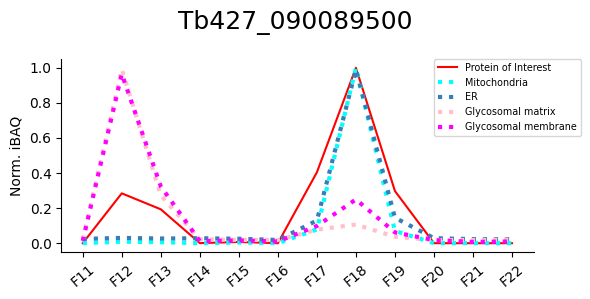

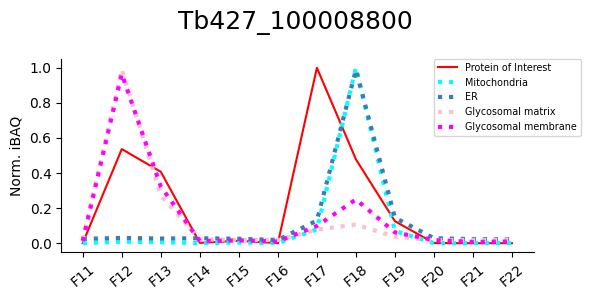

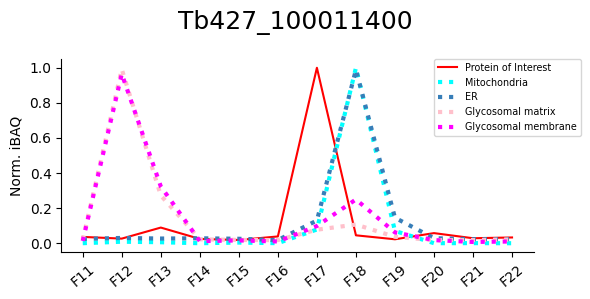

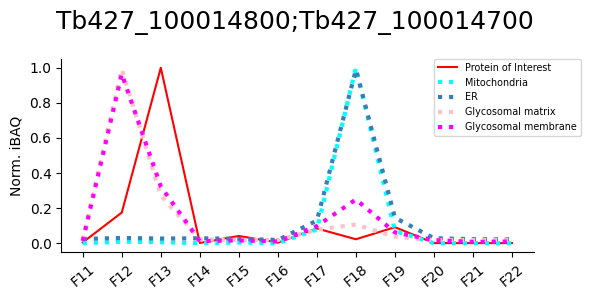

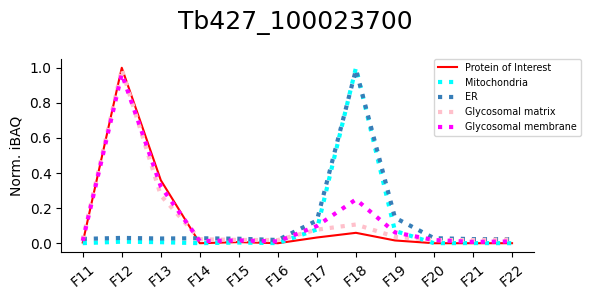

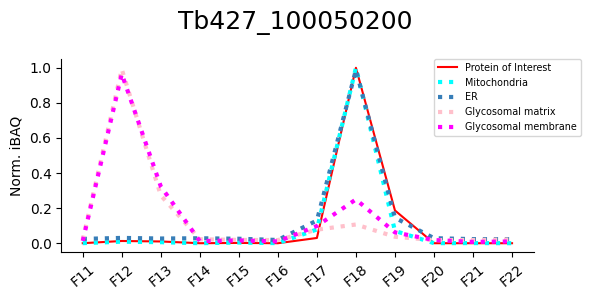

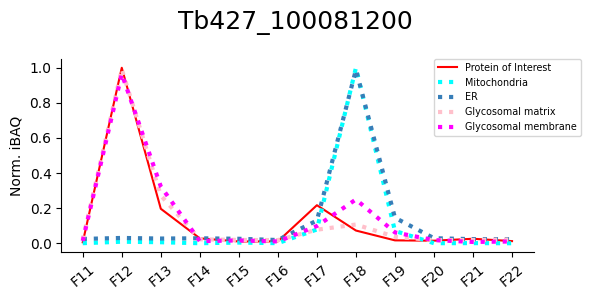

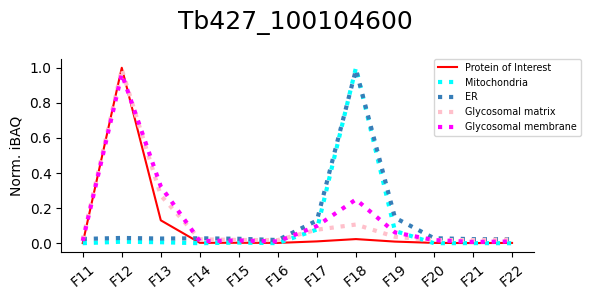

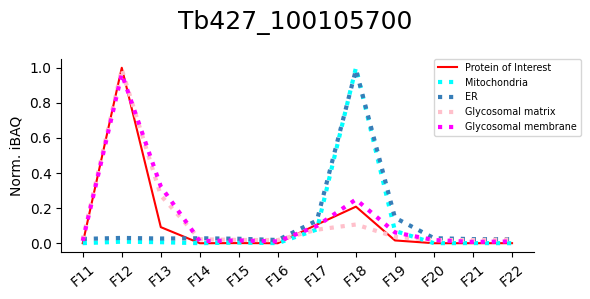

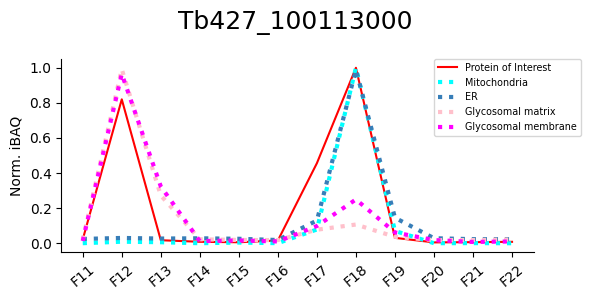

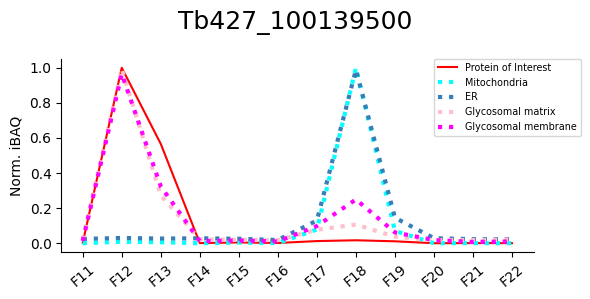

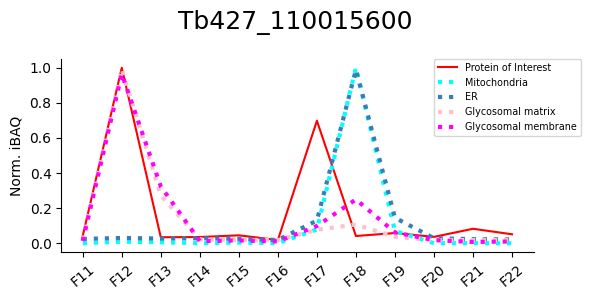

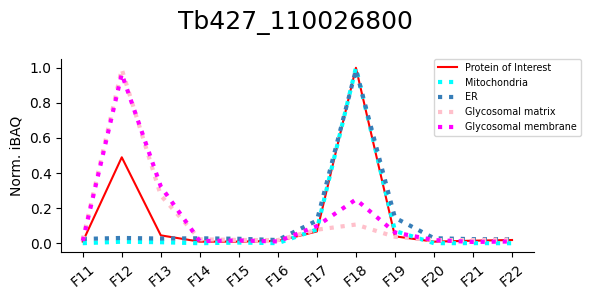

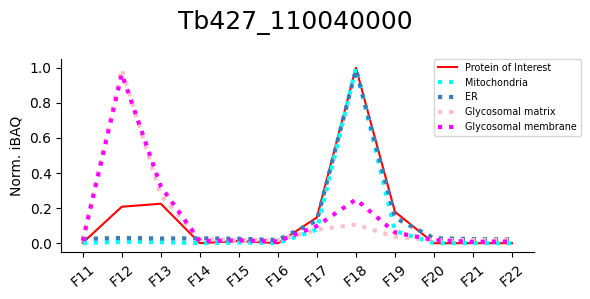

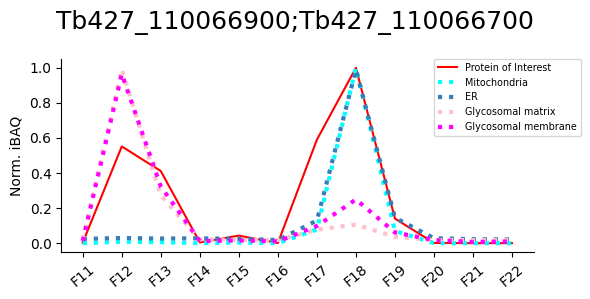

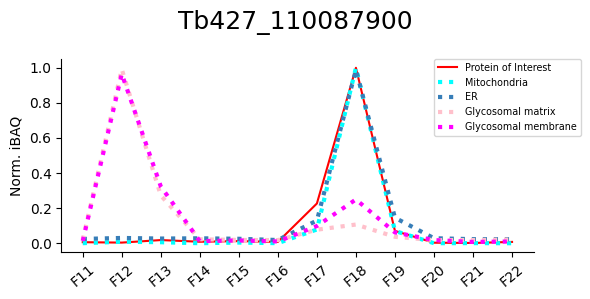

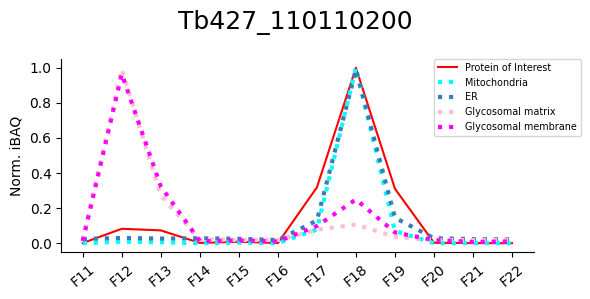

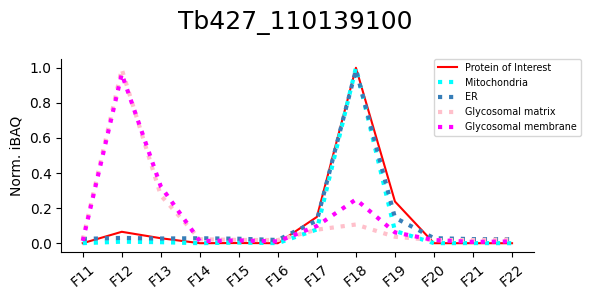

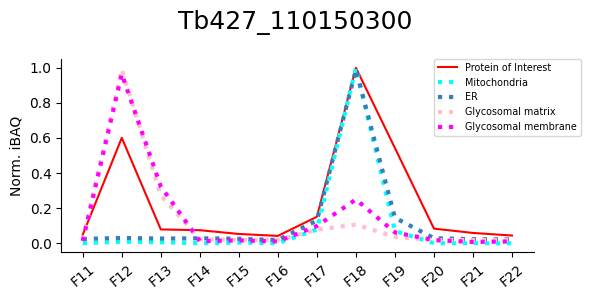

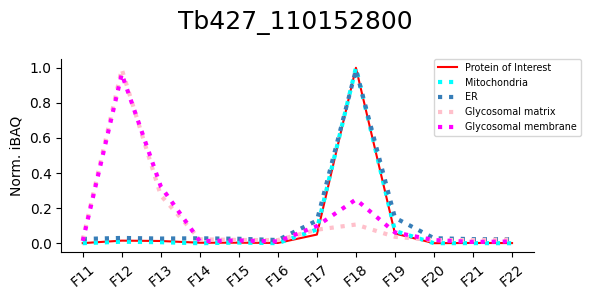

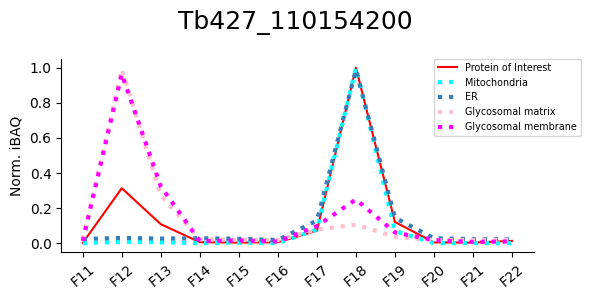

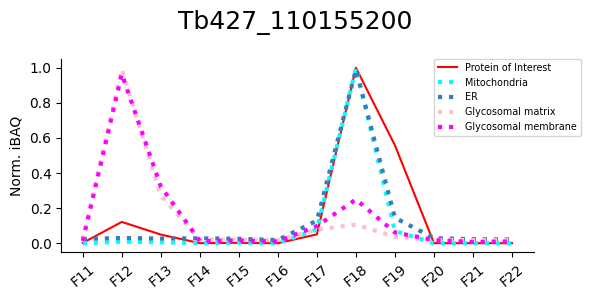

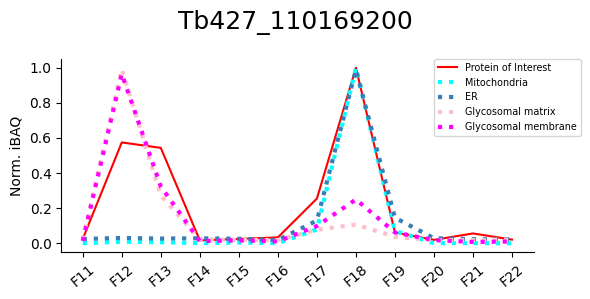

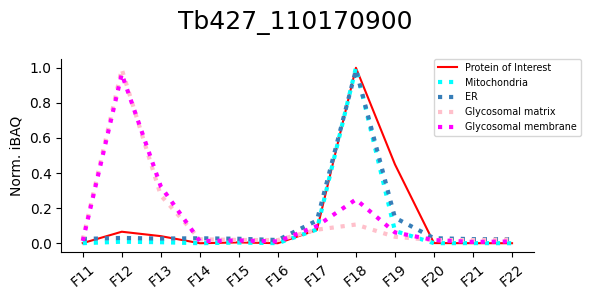

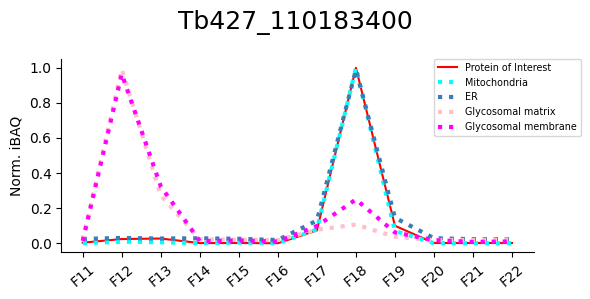

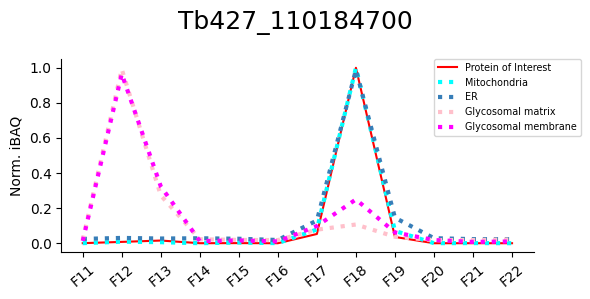

In [295]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Create a PDF file to save all plots
with PdfPages("results/density_profiles_Class2_proteins.pdf") as pdf:
    # Main plotting code
    for p in poi:
        fig, ax = plt.subplots(figsize=(6, 3))
        fig.suptitle(p, size=18)

        # Plotting traces for a single column
        vis.plot_traces(rep1[rep1['Majority protein IDs']==p], intCol1, ax=ax, plot_summary_only=False, color="red", ylabel='Norm. iBAQ', label='Protein of Interest')
        ticks = ['F11','F12', 'F13','F14','F15','F16', 'F17','F18','F19', 'F20','F21','F22']

        vis.plot_traces(rep1[rep1['marker'] == 'Mitochondria'], intCol1, ax=ax, plot_summary_only=True, summary_color="cyan", summary_style='dotted', ylabel='Norm. iBAQ', label='Mitochondria')
        vis.plot_traces(rep1[rep1['marker'] == 'ER'], intCol1, ax=ax, plot_summary_only=True, summary_color="#377eb8", summary_style='dotted', ylabel='Norm. iBAQ', label='ER')
        
        vis.plot_traces(rep1[rep1['marker'] == 'Glycosomal matrix'], intCol1, ax=ax, plot_summary_only=True, summary_color="pink", summary_style='dotted', ylabel='Norm. iBAQ', label='Glycosomal matrix')
        vis.plot_traces(rep1[rep1['marker'] == 'Glycosomal membrane'], intCol1, ax=ax, plot_summary_only=True, summary_color="magenta", summary_style='dotted', ylabel='Norm. iBAQ', label='Glycosomal membrane')        
        
        ax.set_xticks(range(len(ticks)))
        ax.set_xticklabels(ticks, rotation=40, ha='center')
        
        # Add legend
        ax.legend(loc='upper right', fontsize='x-small', bbox_to_anchor=(1.1, 1), borderaxespad=0.)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save the current figure to the PDF
        pdf.savefig(fig, bbox_inches='tight')
        
        # Close the figure to free up memory
        # plt.close(fig)

# The PDF file is automatically saved and closed after the with block